In [28]:
#!unzip drive/MyDrive/Pets-data/images.zip
#!cp -r drive/MyDrive/Pets-data/annotations .
#!ls

In [65]:
import os
import yaml
from typing import Tuple, List

import torch
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
from pydantic import BaseModel
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import copy
import optuna
import joblib

In [30]:
# Define constants

CONFIG_FILE_PATH = 'config-mixmatch.yaml'
IMAGE_COL_IDX = 0
CLASS_ID_COL_IDX = 1
SPECIES_COL_IDX = 2
POSSIBLE_NUM_CLASSES = {2, 37}
T = 0.5

In [31]:
class AdamOptimizerConfig(BaseModel):
    lr: float
    weight_decay: float

In [32]:
class Config(BaseModel):
    device: str
    num_classes: int
    batch_size: int
    max_num_epochs: int
    patience: int
    adam_optimizer_config: AdamOptimizerConfig
    num_batch_norm_layers_to_train_params: int
    num_batch_norm_layers_to_update_running_stats: int
    train_earlier_layers_delay: int
    n_hidden_layers_to_train: int
    labelled_data_ratio: float
    ema_decay: float
    lambda_u_epoch_max: int
    alpha: float
    lambda_u: float

In [33]:
with open(CONFIG_FILE_PATH, encoding='utf-8') as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)

config = Config.model_validate(config_dict)

assert config.num_classes in POSSIBLE_NUM_CLASSES
assert 0 <= config.num_batch_norm_layers_to_train_params <= 36  # 36 batch norm layers in resnet34
assert 0 <= config.num_batch_norm_layers_to_update_running_stats <= 36  # 36 batch norm layers in resnet34

In [34]:
# K = 2
class TransformTwice(nn.Module):
    def __init__(self, transformation):
        super().__init__()
        self.transformation = transformation

    def __call__(self, data):
        return self.transformation(data), self.transformation(data)

In [35]:
class LabelledImageDataset(Dataset):
    def __init__(self, filenames: List[str], labels: List[int], use_augmentations: bool) -> None:
        self.filenames = filenames
        self.labels = labels
        # self.transformation = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        self.transformation = (
            transforms.Compose([
                torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms(),
                # transforms.RandomCrop((what size, what other size)),
                transforms.RandomHorizontalFlip(),
                # transforms.RandomRotation((-10, 10)),
                # transforms.RandomErasing(),
            ])
            if use_augmentations
            else torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        )

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = Image.open(os.path.join('images', f'{self.filenames[idx]}.jpg')).convert('RGB')
        label = self.labels[idx]

        transformed_img = self.transformation(image)

        return transformed_img.to(config.device), torch.tensor(label).to(config.device)

In [36]:
class UnlabelledImageDataset(Dataset):
    def __init__(self, filenames: List[str], use_augmentations: bool) -> None:
        self.filenames = filenames
        # self.transformation = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        self.transformation = (
            transforms.Compose([
                torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms(),
                # transforms.RandomCrop((what size, what other size)),
                TransformTwice(transforms.RandomHorizontalFlip()),
                # transforms.RandomRotation((-10, 10)),
                # transforms.RandomErasing(),
            ])
            if use_augmentations
            else torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        )

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = Image.open(os.path.join('images', f'{self.filenames[idx]}.jpg')).convert('RGB')

        transformed_img, transformed_img_2 = self.transformation(image)

        return transformed_img.to(config.device), transformed_img_2.to(config.device)

In [37]:
def get_image_names_and_labels(annotations_file_path: str, num_classes: int) -> Tuple[List[str], List[int]]:
    filenames: List[str] = []
    labels: List[int] = []

    with open(annotations_file_path, encoding='utf-8') as f:
        lines = f.readlines()

    label_col_idx = SPECIES_COL_IDX if num_classes == 2 else CLASS_ID_COL_IDX

    for line in lines:
        line_split = line.split()
        filenames.append(line_split[IMAGE_COL_IDX])
        labels.append(int(line_split[label_col_idx]) - 1)

    return filenames, labels

In [38]:
def get_batch_norm_layers(model: nn.Module) -> List[nn.Module]:
    return [
        module
        for module in model.modules()
        if isinstance(module, nn.BatchNorm2d)
    ]

In [39]:
def get_pretrained_model_with_trainable_last_layer(num_batch_norm_layers_to_train_params: int) -> nn.Module:
    model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    batch_norm_layers = get_batch_norm_layers(model)
    batch_norm_layers_to_train_params = batch_norm_layers[-num_batch_norm_layers_to_train_params:] if num_batch_norm_layers_to_train_params else []

    for batch_norm_layer in batch_norm_layers_to_train_params:
        for param in batch_norm_layer.parameters():
            param.requires_grad = True

    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=config.num_classes)

    return model.to(config.device)

In [40]:
def make_hidden_layers_trainable(model: nn.Module, number_of_hidden_layers_to_train: int) -> nn.Module:
    trainable_layers = [layer for layer in model.modules() if not isinstance(layer, torchvision.models.resnet.ResNet) and not isinstance(layer, torchvision.models.resnet.BasicBlock) and not isinstance(layer, nn.Sequential) and not isinstance(layer, nn.Sequential) and len(list(layer.parameters())) > 0]
    trainable_layers = list(reversed(trainable_layers[:-1]))

    for l in trainable_layers[:number_of_hidden_layers_to_train]:
        for p in l.parameters():
            p.requires_grad = True

    return model

In [41]:
def get_model_accuracy(model: nn.Module, data_loader: DataLoader) -> float:
    correct_predictions_cnt = 0
    total_predictions_cnt = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Computing accuracy'):
            outputs = model(inputs)
            correct_predictions_cnt += (torch.argmax(outputs, axis=1) == labels).sum()
            total_predictions_cnt += len(outputs)
    return correct_predictions_cnt / total_predictions_cnt

In [42]:
def mix_up(X_1, X_2, Y_1, Y_2, config):
    assert X_1.shape == X_2.shape, 'mix_up: inputs must have same size'
    X = []
    Y = []
    for i in range(len(X_1)):
        x_1 = X_1[i]
        x_2 = X_2[i]
        y_1 = Y_1[i]
        y_2 = Y_2[i]
        l = np.random.beta(config.alpha, config.alpha)
        l = max(l, (1-l))
        x = l * x_1 + (1-l) * x_2
        y = l * y_1 + (1-l) * y_2

        X.append(x)
        Y.append(y)
    return torch.stack(X), torch.stack(Y)

In [43]:
def linear_rampup(epoch, config):
    return float(min(epoch / config.lambda_u_epoch_max, 1))

In [44]:
class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch, config):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu, config.lambda_u * linear_rampup(epoch, config)

In [45]:
def update_ema_parameters(model, ema_model, ema_decay=0.999):
    with torch.no_grad():
        for ema_param, param in zip(ema_model.parameters(), model.parameters()):
            ema_param.data.copy_(ema_param.data * ema_decay + (1 - ema_decay) * param.data)

In [46]:
def infinite_batch_generator(loader: DataLoader):
    while True:
        for batch in loader:
            yield batch


def train_single_epoch(
        model: nn.Module,
        ema_model: nn.Module,        
        train_data_loader: DataLoader,
        unlabelled_train_data_loader: DataLoader,
        criterion: SemiLoss,
        optimizer: torch.optim.Optimizer,
        num_batch_norm_layers_to_update_running_stats: int,
        epoch: int,
        config: Config
        ) -> float:
    model.train()
    batch_norm_layers = get_batch_norm_layers(model)
    batch_norm_layers_to_not_update_running_stats = (
        batch_norm_layers[:-num_batch_norm_layers_to_update_running_stats]
        if num_batch_norm_layers_to_update_running_stats
        else batch_norm_layers
    )
    for batch_norm_layer in batch_norm_layers_to_not_update_running_stats:
        batch_norm_layer.eval()
    train_loss_sum = 0.0
    train_samples_cnt = 0

    unlabelled_generator = infinite_batch_generator(unlabelled_train_data_loader)

    for labelled_inputs, labelled_targets in tqdm(train_data_loader, desc='Training model'):

        labelled_targets = F.one_hot(labelled_targets, config.num_classes)
        unlabelled_inputs_1, unlabelled_inputs_2 = next(unlabelled_generator)
        unlabelled_inputs = torch.cat([unlabelled_inputs_1, unlabelled_inputs_2])

        # Calculated the pseudo label for each of the augmented unlabeled data point
        with torch.no_grad():
            u_o_1 = model(unlabelled_inputs_1)
            u_o_2 = model(unlabelled_inputs_2)
            unlabelled_targets = (F.softmax(u_o_1, dim=1) + F.softmax(u_o_2, dim=1)) / 2
            unlabelled_targets = unlabelled_targets**(1/T)
            unlabelled_targets = unlabelled_targets / unlabelled_targets.sum(dim=1, keepdim=True)

        all_inputs = torch.cat([labelled_inputs, unlabelled_inputs_1, unlabelled_inputs_2])
        all_targets = torch.cat([labelled_targets, unlabelled_targets, unlabelled_targets])
        idxs = np.random.permutation(len(all_inputs))
        all_inputs = all_inputs[idxs]
        all_targets = all_targets[idxs]

        X, targets_X = mix_up(labelled_inputs, all_inputs[:len(labelled_inputs)], labelled_targets, all_targets[:len(labelled_inputs)], config)
        U, targets_U = mix_up(unlabelled_inputs, all_inputs[len(labelled_inputs):], torch.cat([unlabelled_targets, unlabelled_targets]), all_targets[len(labelled_inputs):], config)

        outputs_X = model(X)
        outputs_U = model(U)

        LX, LU, lamb_u = criterion(outputs_X, targets_X, outputs_U, targets_U, epoch, config)

        optimizer.zero_grad()
        loss = LX + lamb_u * LU
        loss.backward()
        optimizer.step()
        update_ema_parameters(model, ema_model, config.ema_decay)
        train_loss_sum += loss.item() * (len(outputs_X) + len(outputs_U))
        train_samples_cnt += len(outputs_X) + len(outputs_U)

    return train_loss_sum / train_samples_cnt

In [47]:
def save_checkpoint(model: nn.Module, optimizer: torch.optim.Optimizer) -> Tuple[nn.Module, torch.optim.Optimizer]:
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, 'checkpoint.pt')

In [48]:
def load_checkpoint(model: nn.Module, optimizer: torch.optim.Optimizer) -> None:
    checkpoint = torch.load('checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [49]:
filenames_trainval, labels_trainval = get_image_names_and_labels('annotations/trainval.txt', num_classes=config.num_classes)
filenames_test, labels_test = get_image_names_and_labels('annotations/test.txt', num_classes=config.num_classes)
filenames_train, filenames_val, labels_train, labels_val = train_test_split(filenames_trainval, labels_trainval, test_size=0.2, stratify=labels_trainval)

filenames_train, unlabelled_filenames_train, labels_train, _ = train_test_split(filenames_train, labels_train, train_size=config.labelled_data_ratio, stratify=labels_train)
dataset_train = LabelledImageDataset(filenames_train, labels_train, use_augmentations=True)
unlabelled_dataset_train = UnlabelledImageDataset(unlabelled_filenames_train, use_augmentations=True)

dataset_val = LabelledImageDataset(filenames_val, labels_val, use_augmentations=False)
dataset_test = LabelledImageDataset(filenames_test, labels_test, use_augmentations=False)

unlabelled_train_data_loader = DataLoader(unlabelled_dataset_train, batch_size=config.batch_size, shuffle=True)
train_data_loader = DataLoader(dataset_train, batch_size=config.batch_size, shuffle=True)
val_data_loader = DataLoader(dataset_val, batch_size=config.batch_size, shuffle=False)
test_data_loader = DataLoader(dataset_test, batch_size=config.batch_size, shuffle=False)

In [50]:
# Train using pseudo labelling
def train_model(config: Config):
    model = get_pretrained_model_with_trainable_last_layer(config.num_batch_norm_layers_to_train_params)
    ema_model = copy.deepcopy(model)

    criterion = SemiLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.adam_optimizer_config.lr, weight_decay=config.adam_optimizer_config.weight_decay)

    max_val_accuracy = float('-inf')
    argmax_epoch = -1

    for epoch in range(config.max_num_epochs):
        print(f'Epoch #{epoch}:')
        train_loss = train_single_epoch(model, ema_model, train_data_loader, unlabelled_train_data_loader, criterion, optimizer, config.num_batch_norm_layers_to_update_running_stats, epoch, config)
        print(f'Train loss: {train_loss}')
        val_accuracy = get_model_accuracy(ema_model, val_data_loader)
        if val_accuracy > max_val_accuracy:
            print(f'Validation accuracy: {100 * val_accuracy:.2f}% (new best)')
            max_val_accuracy = val_accuracy
            argmax_epoch = epoch
            save_checkpoint(ema_model, optimizer)
            print('Checkpoint saved')
        else:
            print(f'Validation accuracy: {100 * val_accuracy:.2f}% (worse than {100 * max_val_accuracy:.2f}% of epoch {argmax_epoch})')
            if epoch > argmax_epoch + config.patience:
                print(f'Early stopping')
                break
        # Start training earlier layers
        if epoch == config.train_earlier_layers_delay and config.n_hidden_layers_to_train > 0:
            print (f'Making last {config.n_hidden_layers_to_train} hidden layers trainable')
            make_hidden_layers_trainable(model, config.n_hidden_layers_to_train)
            optimizer = torch.optim.Adam(model.parameters(), lr=config.adam_optimizer_config.lr / 100, weight_decay=config.adam_optimizer_config.weight_decay)
        print()
    return max_val_accuracy

In [51]:
def objective(trial: optuna.Trial):
    config = Config(
        device = 'cuda:0',
        num_classes = 37,
        batch_size = 64,
        max_num_epochs = 400,
        patience = 50,
        adam_optimizer_config = AdamOptimizerConfig(lr = 0.001, weight_decay = 0.0001),
        num_batch_norm_layers_to_train_params = 0,
        num_batch_norm_layers_to_update_running_stats = 0,
        train_earlier_layers_delay = 1000,
        n_hidden_layers_to_train = 0,
        # Parameters for the pseudo label learning
        labelled_data_ratio = 0.1,
        ema_decay = 0.999,
        alpha = 0.75,
        lambda_u = 100,
        lambda_u_epoch_max = 100,
    )
    
    lambda_u = trial.suggest_float('lambda_u', 50, 150)
    alpha = trial.suggest_float('alpha', 0.4, 1)

    config.lambda_u = lambda_u
    config.alpha = alpha

    return train_model(config)



In [52]:
# Train the model
#accuracy = train_model()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print (study.best_params())


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 80.30% (new best)
Checkpoint saved

Epoch #124:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2941744205017416


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 80.30% (worse than 80.30% of epoch 123)

Epoch #125:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3471171130970663


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 80.57% (new best)
Checkpoint saved

Epoch #126:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.331551685067775


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 80.84% (new best)
Checkpoint saved

Epoch #127:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2590743058243452


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 81.25% (new best)
Checkpoint saved

Epoch #128:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.291028207578802


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 81.39% (new best)
Checkpoint saved

Epoch #129:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2566270110949205


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 81.52% (new best)
Checkpoint saved

Epoch #130:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2440322839218239


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 81.79% (new best)
Checkpoint saved

Epoch #131:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2835038285183957


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 81.93% (new best)
Checkpoint saved

Epoch #132:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3341852970245818


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 82.34% (new best)
Checkpoint saved

Epoch #133:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2785044760469195


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 82.34% (worse than 82.34% of epoch 132)

Epoch #134:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2544160070460153


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 82.34% (worse than 82.34% of epoch 132)

Epoch #135:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.35098995947991


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 82.34% (worse than 82.34% of epoch 132)

Epoch #136:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.241290795215958


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 82.47% (new best)
Checkpoint saved

Epoch #137:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3021111217760173


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 82.47% (worse than 82.47% of epoch 136)

Epoch #138:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.35047761122726


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 82.47% (worse than 82.47% of epoch 136)

Epoch #139:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2952372282424371


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Validation accuracy: 82.47% (worse than 82.47% of epoch 136)

Epoch #140:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2577580951265912


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 82.61% (new best)
Checkpoint saved

Epoch #141:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3637512786995931


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 82.74% (new best)
Checkpoint saved

Epoch #142:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2470223319096534


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 83.02% (new best)
Checkpoint saved

Epoch #143:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2632719342152108


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 83.15% (new best)
Checkpoint saved

Epoch #144:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.2997760992233962


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 83.29% (new best)
Checkpoint saved

Epoch #145:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2243465011584427


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 83.29% (worse than 83.29% of epoch 144)

Epoch #146:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3717372251526958


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 83.56% (new best)
Checkpoint saved

Epoch #147:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.2274292138199734


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Validation accuracy: 83.70% (new best)
Checkpoint saved

Epoch #148:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.315256483805001


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 83.97% (new best)
Checkpoint saved

Epoch #149:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2712880546582077


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 84.10% (new best)
Checkpoint saved

Epoch #150:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Train loss: 1.1289387675883684


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 84.24% (new best)
Checkpoint saved

Epoch #151:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.2511502897458617


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 84.65% (new best)
Checkpoint saved

Epoch #152:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2793140561983978


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 84.92% (new best)
Checkpoint saved

Epoch #153:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3108164975678895


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 84.92% (worse than 84.92% of epoch 152)

Epoch #154:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.2864997481380847


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 84.92% (worse than 84.92% of epoch 152)

Epoch #155:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2131403551877693


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 85.19% (new best)
Checkpoint saved

Epoch #156:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2699067924466838


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 85.33% (new best)
Checkpoint saved

Epoch #157:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3761876341617592


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 85.46% (new best)
Checkpoint saved

Epoch #158:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.268691357249111


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 85.46% (worse than 85.46% of epoch 157)

Epoch #159:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3073739175878194


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 85.73% (new best)
Checkpoint saved

Epoch #160:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2707198671916822


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 85.60% (worse than 85.73% of epoch 159)

Epoch #161:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2137875832633238


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 85.46% (worse than 85.73% of epoch 159)

Epoch #162:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2759540703873562


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 85.60% (worse than 85.73% of epoch 159)

Epoch #163:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.342562160093728


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Validation accuracy: 85.60% (worse than 85.73% of epoch 159)

Epoch #164:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2835350529284753


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 159)

Epoch #165:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3518719662946093


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 159)

Epoch #166:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3391722070583694


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 159)

Epoch #167:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2219912242583084


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 159)

Epoch #168:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2311674772544388


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 85.60% (worse than 85.73% of epoch 159)

Epoch #169:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3445328080934937


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 85.60% (worse than 85.73% of epoch 159)

Epoch #170:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2541222929699263


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 85.46% (worse than 85.73% of epoch 159)

Epoch #171:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.311699679883185


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 85.46% (worse than 85.73% of epoch 159)

Epoch #172:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.305266517132712


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 85.60% (worse than 85.73% of epoch 159)

Epoch #173:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2749077548817342


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 86.01% (new best)
Checkpoint saved

Epoch #174:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2291133643728251


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 86.01% (worse than 86.01% of epoch 173)

Epoch #175:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.185719979651735


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 85.87% (worse than 86.01% of epoch 173)

Epoch #176:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2422199591324212


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 85.87% (worse than 86.01% of epoch 173)

Epoch #177:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.2500385768408437


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.01% (worse than 86.01% of epoch 173)

Epoch #178:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3055892843250545


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.14% (new best)
Checkpoint saved

Epoch #179:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2310388606416591


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 178)

Epoch #180:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.330864812373094


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 178)

Epoch #181:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2675152539696377


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.01% (worse than 86.14% of epoch 178)

Epoch #182:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2593936692979146


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.01% (worse than 86.14% of epoch 178)

Epoch #183:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2816669869473967


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 178)

Epoch #184:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.292897442423557


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 86.41% (new best)
Checkpoint saved

Epoch #185:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.23936696838771


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 86.82% (new best)
Checkpoint saved

Epoch #186:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2667660422192395


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 185)

Epoch #187:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2940152998399428


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.96% (new best)
Checkpoint saved

Epoch #188:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2261517167857168


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 87.09% (new best)
Checkpoint saved

Epoch #189:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2438089867985989


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.09% (worse than 87.09% of epoch 188)

Epoch #190:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3000650280803379


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.23% (new best)
Checkpoint saved

Epoch #191:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2400382376840333


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.36% (new best)
Checkpoint saved

Epoch #192:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.25534632425492


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #193:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.192592803620169


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #194:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.268374596213886


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #195:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2578292939596565


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #196:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3603375078013418


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #197:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.2251612461098256


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #198:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2282004249172496


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #199:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.217843913929876


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #200:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2722286726218475


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #201:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.2728002010116741


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 191)

Epoch #202:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2321924915660882


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.50% (new best)
Checkpoint saved

Epoch #203:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2446741103104912


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 202)

Epoch #204:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2803883682737003


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 202)

Epoch #205:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2570600085901755


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 202)

Epoch #206:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2063341556830887


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 202)

Epoch #207:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2163724363233088


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 202)

Epoch #208:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3004890259123971


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 202)

Epoch #209:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.245801147863237


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.64% (new best)
Checkpoint saved

Epoch #210:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2390580629128205


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #211:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3567063331093472


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #212:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.162846434805582


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #213:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.234966204304256


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #214:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.275878071529707


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #215:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.2252247698557197


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #216:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2652400910726707


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #217:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.281084172986049


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #218:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.1681952757294225


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #219:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3827459281210726


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #220:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2471907090323895


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #221:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.260600911728575


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #222:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3059760452082632


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #223:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2732857537218538


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #224:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.1940395278134233


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #225:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2242353143732858


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #226:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.212613923136121


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #227:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2378485743953533


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #228:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.351697214665709


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #229:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2595006156018766


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #230:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3386771367499863


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #231:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.26686668932055


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #232:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3221071174874806


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.23% (worse than 87.64% of epoch 209)

Epoch #233:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.1894410230873484


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.23% (worse than 87.64% of epoch 209)

Epoch #234:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.227961201228728


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #235:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3144113905169468


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #236:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3211427222482652


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #237:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2492185499223958


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #238:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2121288674291246


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #239:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3210602355462835


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #240:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.2310416410005067


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #241:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3181935273094911


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.23% (worse than 87.64% of epoch 209)

Epoch #242:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.1564010731413226


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 87.23% (worse than 87.64% of epoch 209)

Epoch #243:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2334298349805255


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.23% (worse than 87.64% of epoch 209)

Epoch #244:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.258064655981942


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.23% (worse than 87.64% of epoch 209)

Epoch #245:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2652968691554263


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.23% (worse than 87.64% of epoch 209)

Epoch #246:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.243220703504836


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.23% (worse than 87.64% of epoch 209)

Epoch #247:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.2956424341467259


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #248:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2622819579898417


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #249:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.1746019056062882


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #250:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3224590087600643


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 87.36% (worse than 87.64% of epoch 209)

Epoch #251:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2207849214623265


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #252:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2849063056439354


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #253:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.261476945826022


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #254:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.291495057959628


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #255:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3140412714547722


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #256:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.1994739691756777


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #257:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2915918232286767


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #258:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2038159168762108


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #259:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2752165477842539


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)

Epoch #260:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.192221252770189


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]
[I 2024-05-26 23:02:12,732] Trial 13 finished with value: 0.876358687877655 and parameters: {'lambda_u': 74.72250876979828, 'alpha': 0.4857157109181175}. Best is trial 3 with value: 0.89673912525177.


Validation accuracy: 87.50% (worse than 87.64% of epoch 209)
Early stopping
Epoch #0:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 3.7265661115054143


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 2.99% (new best)
Checkpoint saved

Epoch #1:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 3.314822408831349


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 2.99% (worse than 2.99% of epoch 0)

Epoch #2:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 2.9410270552053186


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 2.99% (worse than 2.99% of epoch 0)

Epoch #3:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 2.712035746850089


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 2.99% (worse than 2.99% of epoch 0)

Epoch #4:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 2.422037414105597


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 2.99% (worse than 2.99% of epoch 0)

Epoch #5:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 2.170699160410454


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 2.99% (worse than 2.99% of epoch 0)

Epoch #6:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 2.068164638074103


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 3.12% (new best)
Checkpoint saved

Epoch #7:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.9914767241835338


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 3.26% (new best)
Checkpoint saved

Epoch #8:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.8321595112823061


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 3.40% (new best)
Checkpoint saved

Epoch #9:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.71469300640727


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 3.53% (new best)
Checkpoint saved

Epoch #10:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.7135610092886


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 3.53% (worse than 3.53% of epoch 9)

Epoch #11:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.741431654903567


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 3.53% (worse than 3.53% of epoch 9)

Epoch #12:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6722151309060336


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 3.80% (new best)
Checkpoint saved

Epoch #13:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6361770492039094


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 3.94% (new best)
Checkpoint saved

Epoch #14:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Train loss: 1.617051401791787


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 4.48% (new best)
Checkpoint saved

Epoch #15:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6075686905572961


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 4.76% (new best)
Checkpoint saved

Epoch #16:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6574217517575054


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 5.03% (new best)
Checkpoint saved

Epoch #17:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6098880173052148


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 5.30% (new best)
Checkpoint saved

Epoch #18:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4790173564784277


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 5.30% (worse than 5.30% of epoch 17)

Epoch #19:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4768791428469998


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 5.30% (worse than 5.30% of epoch 17)

Epoch #20:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.508971848375537


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 5.98% (new best)
Checkpoint saved

Epoch #21:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5914819498388875


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 6.52% (new best)
Checkpoint saved

Epoch #22:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4678777458836232


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 6.93% (new best)
Checkpoint saved

Epoch #23:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.588597795182173


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 7.47% (new best)
Checkpoint saved

Epoch #24:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4573826174664548


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Validation accuracy: 8.15% (new best)
Checkpoint saved

Epoch #25:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4998057319980107


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 8.42% (new best)
Checkpoint saved

Epoch #26:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5760279794321326


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 9.24% (new best)
Checkpoint saved

Epoch #27:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5233512215747058


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 9.38% (new best)
Checkpoint saved

Epoch #28:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5393976904850701


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 9.92% (new best)
Checkpoint saved

Epoch #29:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4378026557938701


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 10.19% (new best)
Checkpoint saved

Epoch #30:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5317393758312283


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 11.01% (new best)
Checkpoint saved

Epoch #31:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4770540961361545


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 11.68% (new best)
Checkpoint saved

Epoch #32:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4579296127376515


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 11.96% (new best)
Checkpoint saved

Epoch #33:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.506751583015638


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 12.91% (new best)
Checkpoint saved

Epoch #34:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4295570564474231


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 13.32% (new best)
Checkpoint saved

Epoch #35:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5599778089074048


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 13.86% (new best)
Checkpoint saved

Epoch #36:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4289609816651272


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 14.67% (new best)
Checkpoint saved

Epoch #37:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.438516325562618


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 15.49% (new best)
Checkpoint saved

Epoch #38:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4084987579116985


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 16.17% (new best)
Checkpoint saved

Epoch #39:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5868562100020416


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 16.98% (new best)
Checkpoint saved

Epoch #40:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.448160628435188


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 18.61% (new best)
Checkpoint saved

Epoch #41:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4694220700662193


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 19.29% (new best)
Checkpoint saved

Epoch #42:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.5067350392168033


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 19.84% (new best)
Checkpoint saved

Epoch #43:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.538458698822038


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 20.52% (new best)
Checkpoint saved

Epoch #44:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.55898013538671


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 21.47% (new best)
Checkpoint saved

Epoch #45:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5359296507702649


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 22.69% (new best)
Checkpoint saved

Epoch #46:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4936810609360067


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 23.23% (new best)
Checkpoint saved

Epoch #47:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5229134929767258


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 24.32% (new best)
Checkpoint saved

Epoch #48:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5970769760695465


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 25.00% (new best)
Checkpoint saved

Epoch #49:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4840025092600755


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 26.36% (new best)
Checkpoint saved

Epoch #50:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5136763020807467


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 26.90% (new best)
Checkpoint saved

Epoch #51:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4880860038181445


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 28.12% (new best)
Checkpoint saved

Epoch #52:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.586282758181815


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 29.08% (new best)
Checkpoint saved

Epoch #53:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.5311243914434691


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 30.43% (new best)
Checkpoint saved

Epoch #54:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5616377525717595


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 30.84% (new best)
Checkpoint saved

Epoch #55:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4515028382777146


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 31.93% (new best)
Checkpoint saved

Epoch #56:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4869483533201688


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 32.88% (new best)
Checkpoint saved

Epoch #57:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5259484014368159


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 33.83% (new best)
Checkpoint saved

Epoch #58:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5066537994899383


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 35.05% (new best)
Checkpoint saved

Epoch #59:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5092835436541212


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 36.28% (new best)
Checkpoint saved

Epoch #60:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4863059653459831


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 38.04% (new best)
Checkpoint saved

Epoch #61:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4927923725299712


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 38.72% (new best)
Checkpoint saved

Epoch #62:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5758609059535973


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 39.54% (new best)
Checkpoint saved

Epoch #63:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.5539197985569466


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 40.62% (new best)
Checkpoint saved

Epoch #64:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4228849403352757


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 41.30% (new best)
Checkpoint saved

Epoch #65:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4475503100572868


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 42.39% (new best)
Checkpoint saved

Epoch #66:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5204889781980495


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 43.34% (new best)
Checkpoint saved

Epoch #67:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.560319506381768


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.77it/s]


Validation accuracy: 44.84% (new best)
Checkpoint saved

Epoch #68:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4870529256489853


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 45.38% (new best)
Checkpoint saved

Epoch #69:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.605725278946266


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 47.01% (new best)
Checkpoint saved

Epoch #70:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5200753561689715


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 48.37% (new best)
Checkpoint saved

Epoch #71:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6483632961738799


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 49.32% (new best)
Checkpoint saved

Epoch #72:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.6147167207852675


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 50.27% (new best)
Checkpoint saved

Epoch #73:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.5942376129632334


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 51.22% (new best)
Checkpoint saved

Epoch #74:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5033311971505143


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]


Validation accuracy: 52.45% (new best)
Checkpoint saved

Epoch #75:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5092057964786472


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 53.26% (new best)
Checkpoint saved

Epoch #76:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5367666220001286


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 54.08% (new best)
Checkpoint saved

Epoch #77:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3929113629543297


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 55.16% (new best)
Checkpoint saved

Epoch #78:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5758017212216298


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 55.57% (new best)
Checkpoint saved

Epoch #79:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5274800682476297


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 56.39% (new best)
Checkpoint saved

Epoch #80:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5950251764097356


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 57.74% (new best)
Checkpoint saved

Epoch #81:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6374712087357581


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 58.70% (new best)
Checkpoint saved

Epoch #82:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5984494800996474


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 59.51% (new best)
Checkpoint saved

Epoch #83:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.669754412240594


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 60.05% (new best)
Checkpoint saved

Epoch #84:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.562158144260627


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 61.01% (new best)
Checkpoint saved

Epoch #85:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6117953613432368


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 62.09% (new best)
Checkpoint saved

Epoch #86:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5074674319914627


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 63.59% (new best)
Checkpoint saved

Epoch #87:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.6039778573610033


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 64.13% (new best)
Checkpoint saved

Epoch #88:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6232832356234435


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Validation accuracy: 64.67% (new best)
Checkpoint saved

Epoch #89:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6309963630659932


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 66.17% (new best)
Checkpoint saved

Epoch #90:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5202822955823811


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 67.26% (new best)
Checkpoint saved

Epoch #91:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6408824736862673


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 67.80% (new best)
Checkpoint saved

Epoch #92:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5922229849041403


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 68.21% (new best)
Checkpoint saved

Epoch #93:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6086490164477003


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 68.61% (new best)
Checkpoint saved

Epoch #94:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6431786968059663


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 69.84% (new best)
Checkpoint saved

Epoch #95:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.674452017410409


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 70.65% (new best)
Checkpoint saved

Epoch #96:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.7625545475161306


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 71.20% (new best)
Checkpoint saved

Epoch #97:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.619329792018621


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 72.01% (new best)
Checkpoint saved

Epoch #98:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5414716321855337


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 72.42% (new best)
Checkpoint saved

Epoch #99:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5111873466401846


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 73.64% (new best)
Checkpoint saved

Epoch #100:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6629039396310517


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 74.32% (new best)
Checkpoint saved

Epoch #101:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6832100295918402


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 74.86% (new best)
Checkpoint saved

Epoch #102:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6212481752963341


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 75.54% (new best)
Checkpoint saved

Epoch #103:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6384335860961


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 75.54% (worse than 75.54% of epoch 102)

Epoch #104:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6187394798695403


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 76.09% (new best)
Checkpoint saved

Epoch #105:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.600930724460512


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 76.77% (new best)
Checkpoint saved

Epoch #106:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Train loss: 1.581393310293651


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 76.77% (worse than 76.77% of epoch 105)

Epoch #107:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.8015416625735592


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 77.17% (new best)
Checkpoint saved

Epoch #108:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6495291510281778


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 77.85% (new best)
Checkpoint saved

Epoch #109:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.7204028120388055


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 78.80% (new best)
Checkpoint saved

Epoch #110:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5712506046131796


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 79.21% (new best)
Checkpoint saved

Epoch #111:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6310590605153772


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 80.16% (new best)
Checkpoint saved

Epoch #112:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6771904419014745


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 80.30% (new best)
Checkpoint saved

Epoch #113:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6231731791567752


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 80.71% (new best)
Checkpoint saved

Epoch #114:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6289970770127258


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 80.98% (new best)
Checkpoint saved

Epoch #115:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.549240901842873


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 81.11% (new best)
Checkpoint saved

Epoch #116:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.692365215983585


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 81.25% (new best)
Checkpoint saved

Epoch #117:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.651900162533468


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 81.11% (worse than 81.25% of epoch 116)

Epoch #118:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.6082161177404433


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 81.39% (new best)
Checkpoint saved

Epoch #119:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5597835955323702


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Validation accuracy: 81.79% (new best)
Checkpoint saved

Epoch #120:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6181964432657148


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 82.20% (new best)
Checkpoint saved

Epoch #121:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.6831434646050987


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 82.34% (new best)
Checkpoint saved

Epoch #122:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5546260081726173


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 82.47% (new best)
Checkpoint saved

Epoch #123:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6383267658936136


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 82.88% (new best)
Checkpoint saved

Epoch #124:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.562140547999478


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 83.56% (new best)
Checkpoint saved

Epoch #125:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.677394885577788


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 83.97% (new best)
Checkpoint saved

Epoch #126:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5936042060178148


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 84.10% (new best)
Checkpoint saved

Epoch #127:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.582429168055859


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 84.10% (worse than 84.10% of epoch 126)

Epoch #128:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6110259937780573


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 84.51% (new best)
Checkpoint saved

Epoch #129:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.59154291530748


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 84.78% (new best)
Checkpoint saved

Epoch #130:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6750784818824915


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 84.78% (worse than 84.78% of epoch 129)

Epoch #131:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.5904729501593546


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 85.33% (new best)
Checkpoint saved

Epoch #132:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.556336873093305


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 85.46% (new best)
Checkpoint saved

Epoch #133:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.736805120678479


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 85.73% (new best)
Checkpoint saved

Epoch #134:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6452996028822546


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 85.87% (new best)
Checkpoint saved

Epoch #135:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5870564588898


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 85.73% (worse than 85.87% of epoch 134)

Epoch #136:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6335529903273


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 85.60% (worse than 85.87% of epoch 134)

Epoch #137:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6042110358366874


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 85.73% (worse than 85.87% of epoch 134)

Epoch #138:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.625788146984909


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 85.73% (worse than 85.87% of epoch 134)

Epoch #139:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5876389514710714


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.73% (worse than 85.87% of epoch 134)

Epoch #140:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6210495317773594


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 85.73% (worse than 85.87% of epoch 134)

Epoch #141:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Train loss: 1.5738896746706912


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 85.73% (worse than 85.87% of epoch 134)

Epoch #142:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.558062004838817


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 85.73% (worse than 85.87% of epoch 134)

Epoch #143:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6355497791118745


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.14% (new best)
Checkpoint saved

Epoch #144:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.598118979619453


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 86.55% (new best)
Checkpoint saved

Epoch #145:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.662108551000885


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 144)

Epoch #146:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.57769929265057


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.82% (new best)
Checkpoint saved

Epoch #147:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6099705264706172


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 146)

Epoch #148:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.5514887259910142


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.23% (new best)
Checkpoint saved

Epoch #149:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5930085166873973


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.23% (worse than 87.23% of epoch 148)

Epoch #150:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5920636845349756


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.36% (new best)
Checkpoint saved

Epoch #151:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6892889255629873


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.23% (worse than 87.36% of epoch 150)

Epoch #152:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5240998015413958


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.23% (worse than 87.36% of epoch 150)

Epoch #153:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6236310612721412


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.23% (worse than 87.36% of epoch 150)

Epoch #154:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5618233027243766


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.23% (worse than 87.36% of epoch 150)

Epoch #155:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6613300898345686


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.30it/s]


Validation accuracy: 87.50% (new best)
Checkpoint saved

Epoch #156:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5997568473570862


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 155)

Epoch #157:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.558379564091276


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 155)

Epoch #158:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5464644620964818


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 155)

Epoch #159:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5532626390967685


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 155)

Epoch #160:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5745726611935862


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.23% (worse than 87.50% of epoch 155)

Epoch #161:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6472187049894313


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.23% (worse than 87.50% of epoch 155)

Epoch #162:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5656460684423017


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.23% (worse than 87.50% of epoch 155)

Epoch #163:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.6238829259954122


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 155)

Epoch #164:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5318633915270166


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 155)

Epoch #165:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.6375727587134221


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Validation accuracy: 87.77% (new best)
Checkpoint saved

Epoch #166:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6154283762488681


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 165)

Epoch #167:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5034179802369765


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.91% (new best)
Checkpoint saved

Epoch #168:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6370711142807497


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 167)

Epoch #169:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5263654843642829


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 167)

Epoch #170:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.59798561658798


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 167)

Epoch #171:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5909085590272696


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 167)

Epoch #172:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.6194972067879916


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 167)

Epoch #173:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5620150244465731


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 167)

Epoch #174:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5686225002787098


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 167)

Epoch #175:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6997820705622115


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 167)

Epoch #176:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6809616915929497


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 88.04% (new best)
Checkpoint saved

Epoch #177:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6315399747844426


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #178:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5245698534702081


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 176)

Epoch #179:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6470260803908812


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 176)

Epoch #180:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5899568147781828


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #181:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5873904394133442


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #182:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5545595779664


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #183:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5907598284633564


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #184:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5923685795234663


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #185:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.536643959470173


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #186:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.587573828482781


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #187:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5567562199762086


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #188:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.663740374036213


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #189:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5073422601953053


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 176)

Epoch #190:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4568766600570024


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 176)

Epoch #191:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6091163686817667


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.50% (worse than 88.04% of epoch 176)

Epoch #192:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5833567988438575


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 176)

Epoch #193:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.687014055456288


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #194:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.574980243880948


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #195:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5587155497303866


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #196:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5828825870979522


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #197:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.630964840760323


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #198:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5923717399736033


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #199:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.5819389661833867


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #200:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.574527213353927


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #201:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6516913295557973


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #202:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5356764880186484


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #203:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5824664828608836


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #204:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5660576294525277


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #205:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6245258025489986


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #206:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.607142240128119


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #207:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.578365026755813


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #208:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.571079574254136


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #209:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6542733323140113


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #210:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6067612982919435


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #211:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4274430545545491


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #212:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5457068880824512


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #213:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.580317387999508


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #214:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.594760260183755


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #215:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.6249816701039512


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #216:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.607914241529379


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 176)

Epoch #217:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.628683134371004


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 176)

Epoch #218:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5793317058612244


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 176)

Epoch #219:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5325790781535735


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 176)

Epoch #220:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5522942617056967


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 176)

Epoch #221:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5777265239323488


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #222:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.7261675093362878


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 176)

Epoch #223:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.569091904597313


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #224:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5885175948990489


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 176)

Epoch #225:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5925080799188553


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 176)

Epoch #226:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5371665137738182


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)

Epoch #227:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.558236392713461


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]
[I 2024-05-26 23:21:25,987] Trial 14 finished with value: 0.8804348111152649 and parameters: {'lambda_u': 99.77835928362934, 'alpha': 0.7361633803052008}. Best is trial 3 with value: 0.89673912525177.


Validation accuracy: 87.77% (worse than 88.04% of epoch 176)
Early stopping
Epoch #0:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 3.729632113168786


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 2.58% (new best)
Checkpoint saved

Epoch #1:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 3.2394994469219918


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 2.72% (new best)
Checkpoint saved

Epoch #2:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 2.9022483953316667


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 2.72% (worse than 2.72% of epoch 1)

Epoch #3:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 2.5518371859760816


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Validation accuracy: 2.85% (new best)
Checkpoint saved

Epoch #4:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 2.3039918834188


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 2.85% (worse than 2.85% of epoch 3)

Epoch #5:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 2.052578647846328


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 3.12% (new best)
Checkpoint saved

Epoch #6:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.9219577475839815


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 3.12% (worse than 3.12% of epoch 5)

Epoch #7:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.7924752929736512


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 3.12% (worse than 3.12% of epoch 5)

Epoch #8:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6720042072986383


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 3.40% (new best)
Checkpoint saved

Epoch #9:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.6320736663499786


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 3.53% (new best)
Checkpoint saved

Epoch #10:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5819980559563485


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 3.94% (new best)
Checkpoint saved

Epoch #11:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4542908040563352


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 4.35% (new best)
Checkpoint saved

Epoch #12:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4308388792217672


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 4.35% (worse than 4.35% of epoch 11)

Epoch #13:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4015880669975689


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 4.48% (new best)
Checkpoint saved

Epoch #14:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.367407393149186


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 4.76% (new best)
Checkpoint saved

Epoch #15:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.4003895975537677


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 5.16% (new best)
Checkpoint saved

Epoch #16:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4032311567147233


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 5.57% (new best)
Checkpoint saved

Epoch #17:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4195077523940125


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 5.98% (new best)
Checkpoint saved

Epoch #18:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Train loss: 1.3565999828518331


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 6.66% (new best)
Checkpoint saved

Epoch #19:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2552461047244021


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 6.93% (new best)
Checkpoint saved

Epoch #20:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.3724968854569266


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 7.34% (new best)
Checkpoint saved

Epoch #21:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.393464197438585


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 7.47% (new best)
Checkpoint saved

Epoch #22:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3853568285384577


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 8.02% (new best)
Checkpoint saved

Epoch #23:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2981044888751665


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 8.42% (new best)
Checkpoint saved

Epoch #24:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.3545599384532496


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 8.97% (new best)
Checkpoint saved

Epoch #25:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.38258731288624


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 9.78% (new best)
Checkpoint saved

Epoch #26:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3753139753157884


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 9.92% (new best)
Checkpoint saved

Epoch #27:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.4007552762613562


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 10.33% (new best)
Checkpoint saved

Epoch #28:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3378122268958572


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 11.14% (new best)
Checkpoint saved

Epoch #29:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.2433726907542226


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 12.23% (new best)
Checkpoint saved

Epoch #30:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.1901370754078573


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 12.64% (new best)
Checkpoint saved

Epoch #31:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3113223572104085


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 12.91% (new best)
Checkpoint saved

Epoch #32:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3329618316646306


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 13.59% (new best)
Checkpoint saved

Epoch #33:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2752758877180372


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 14.27% (new best)
Checkpoint saved

Epoch #34:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2997212302761363


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 14.54% (new best)
Checkpoint saved

Epoch #35:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.34785162764392


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 15.08% (new best)
Checkpoint saved

Epoch #36:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3672915186565489


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 15.76% (new best)
Checkpoint saved

Epoch #37:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3999785394178468


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 16.30% (new best)
Checkpoint saved

Epoch #38:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.378002599424162


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 16.98% (new best)
Checkpoint saved

Epoch #39:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3401311467495414


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 17.93% (new best)
Checkpoint saved

Epoch #40:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2978426557536809


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 19.16% (new best)
Checkpoint saved

Epoch #41:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2485295960428373


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 19.57% (new best)
Checkpoint saved

Epoch #42:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.248957367729579


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 20.38% (new best)
Checkpoint saved

Epoch #43:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2811618397526874


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 21.47% (new best)
Checkpoint saved

Epoch #44:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3668400738428186


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 22.28% (new best)
Checkpoint saved

Epoch #45:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3384172395669418


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 23.64% (new best)
Checkpoint saved

Epoch #46:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.2136482339854924


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 24.86% (new best)
Checkpoint saved

Epoch #47:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3874432060396902


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 26.22% (new best)
Checkpoint saved

Epoch #48:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3541018362984667


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 27.72% (new best)
Checkpoint saved

Epoch #49:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2626374804233331


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 29.62% (new best)
Checkpoint saved

Epoch #50:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2910964601300259


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 30.30% (new best)
Checkpoint saved

Epoch #51:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4166016121747917


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 31.39% (new best)
Checkpoint saved

Epoch #52:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3113127660955555


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 32.47% (new best)
Checkpoint saved

Epoch #53:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3357718629040605


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 33.83% (new best)
Checkpoint saved

Epoch #54:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2944482064604503


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 34.65% (new best)
Checkpoint saved

Epoch #55:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.290711942525696


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 35.73% (new best)
Checkpoint saved

Epoch #56:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2861093831521795


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 36.96% (new best)
Checkpoint saved

Epoch #57:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3117171533613186


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 38.04% (new best)
Checkpoint saved

Epoch #58:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3523267341630107


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 39.27% (new best)
Checkpoint saved

Epoch #59:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3404739592264245


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 39.95% (new best)
Checkpoint saved

Epoch #60:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.342080819274935


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 41.17% (new best)
Checkpoint saved

Epoch #61:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3214491695101818


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 42.39% (new best)
Checkpoint saved

Epoch #62:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3916828366877947


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 42.80% (new best)
Checkpoint saved

Epoch #63:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.266322164259835


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 44.16% (new best)
Checkpoint saved

Epoch #64:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3468038994954536


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 45.11% (new best)
Checkpoint saved

Epoch #65:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.333721355146208


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 46.20% (new best)
Checkpoint saved

Epoch #66:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.334305946780987


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 47.83% (new best)
Checkpoint saved

Epoch #67:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2847416842519854


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 48.78% (new best)
Checkpoint saved

Epoch #68:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3654710804880048


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 49.59% (new best)
Checkpoint saved

Epoch #69:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.356140570926462


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 51.36% (new best)
Checkpoint saved

Epoch #70:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.349118527559448


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 52.31% (new best)
Checkpoint saved

Epoch #71:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4022049444390567


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 53.40% (new best)
Checkpoint saved

Epoch #72:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.451146962045347


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 54.21% (new best)
Checkpoint saved

Epoch #73:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.336443371895294


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 54.62% (new best)
Checkpoint saved

Epoch #74:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4284125022765657


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 55.98% (new best)
Checkpoint saved

Epoch #75:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3839738200512381


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 57.20% (new best)
Checkpoint saved

Epoch #76:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3650114196781429


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 58.02% (new best)
Checkpoint saved

Epoch #77:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3548478421613541


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 58.70% (new best)
Checkpoint saved

Epoch #78:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.403254396144532


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 60.46% (new best)
Checkpoint saved

Epoch #79:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2882682263723533


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 61.14% (new best)
Checkpoint saved

Epoch #80:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.424636647583841


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 61.82% (new best)
Checkpoint saved

Epoch #81:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3886146897677436


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 62.36% (new best)
Checkpoint saved

Epoch #82:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.381853643270325


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 62.91% (new best)
Checkpoint saved

Epoch #83:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3883413995358878


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 63.45% (new best)
Checkpoint saved

Epoch #84:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4063616087400939


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 64.54% (new best)
Checkpoint saved

Epoch #85:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.349843474475934


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 65.08% (new best)
Checkpoint saved

Epoch #86:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4677401288418495


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 65.90% (new best)
Checkpoint saved

Epoch #87:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4607568394703834


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 67.12% (new best)
Checkpoint saved

Epoch #88:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4380030249119826


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 67.39% (new best)
Checkpoint saved

Epoch #89:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Train loss: 1.4472079471040844


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 68.34% (new best)
Checkpoint saved

Epoch #90:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4075566078406585


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 68.61% (new best)
Checkpoint saved

Epoch #91:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4917689748188159


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 69.16% (new best)
Checkpoint saved

Epoch #92:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4105013450667485


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 69.70% (new best)
Checkpoint saved

Epoch #93:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.373641654306612


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 70.52% (new best)
Checkpoint saved

Epoch #94:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3633491520708072


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 71.06% (new best)
Checkpoint saved

Epoch #95:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.395033474397353


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 71.47% (new best)
Checkpoint saved

Epoch #96:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3131096710229584


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 72.01% (new best)
Checkpoint saved

Epoch #97:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3200404917147226


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 72.69% (new best)
Checkpoint saved

Epoch #98:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4459418293240238


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 73.10% (new best)
Checkpoint saved

Epoch #99:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5329608884051729


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 73.91% (new best)
Checkpoint saved

Epoch #100:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4955603009373013


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 75.00% (new best)
Checkpoint saved

Epoch #101:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3792267746792615


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 75.54% (new best)
Checkpoint saved

Epoch #102:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.424875684417545


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 75.68% (new best)
Checkpoint saved

Epoch #103:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4248945268880122


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 76.22% (new best)
Checkpoint saved

Epoch #104:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4301048805677916


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 76.36% (new best)
Checkpoint saved

Epoch #105:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4467259055797241


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 76.90% (new best)
Checkpoint saved

Epoch #106:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3624500018370993


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 77.17% (new best)
Checkpoint saved

Epoch #107:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4806345183027378


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 77.45% (new best)
Checkpoint saved

Epoch #108:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3751893855264405


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 77.85% (new best)
Checkpoint saved

Epoch #109:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4206500916205331


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 77.99% (new best)
Checkpoint saved

Epoch #110:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.477724645326684


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 78.12% (new best)
Checkpoint saved

Epoch #111:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.438441596143506


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 78.26% (new best)
Checkpoint saved

Epoch #112:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.412438051858857


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 78.53% (new best)
Checkpoint saved

Epoch #113:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.414356947710989


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 78.80% (new best)
Checkpoint saved

Epoch #114:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5185118548619927


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 79.08% (new best)
Checkpoint saved

Epoch #115:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.5356732392464256


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 79.08% (worse than 79.08% of epoch 114)

Epoch #116:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4549210308961236


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 79.48% (new best)
Checkpoint saved

Epoch #117:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4037584421210931


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 79.76% (new best)
Checkpoint saved

Epoch #118:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.4011977244750846


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 79.76% (worse than 79.76% of epoch 117)

Epoch #119:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3620668529698374


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 79.89% (new best)
Checkpoint saved

Epoch #120:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.5191565055152845


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 80.03% (new best)
Checkpoint saved

Epoch #121:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4342869178130744


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 80.30% (new best)
Checkpoint saved

Epoch #122:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.287899650138757


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 80.30% (worse than 80.30% of epoch 121)

Epoch #123:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.4202332504301052


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 80.43% (new best)
Checkpoint saved

Epoch #124:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.453190567151382


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 80.71% (new best)
Checkpoint saved

Epoch #125:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.460174440571787


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 80.84% (new best)
Checkpoint saved

Epoch #126:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5071497157503246


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 80.98% (new best)
Checkpoint saved

Epoch #127:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.4304822009431728


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 81.11% (new best)
Checkpoint saved

Epoch #128:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5073945004118077


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 81.11% (worse than 81.11% of epoch 127)

Epoch #129:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4963310025233527


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 81.11% (worse than 81.11% of epoch 127)

Epoch #130:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4506080553924756


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 81.25% (new best)
Checkpoint saved

Epoch #131:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4236832670787671


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Validation accuracy: 81.39% (new best)
Checkpoint saved

Epoch #132:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3978820383165838


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 81.93% (new best)
Checkpoint saved

Epoch #133:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4062806753326025


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 82.20% (new best)
Checkpoint saved

Epoch #134:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4071207740832703


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 82.20% (worse than 82.20% of epoch 133)

Epoch #135:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3610502208325796


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 82.20% (worse than 82.20% of epoch 133)

Epoch #136:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3350742884315312


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 82.34% (new best)
Checkpoint saved

Epoch #137:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.41712226602199


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 82.61% (new best)
Checkpoint saved

Epoch #138:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3904896012210233


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 82.61% (worse than 82.61% of epoch 137)

Epoch #139:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.440588176888623


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Validation accuracy: 82.47% (worse than 82.61% of epoch 137)

Epoch #140:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3207768980389745


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 82.47% (worse than 82.61% of epoch 137)

Epoch #141:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.3483257809338784


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 82.61% (worse than 82.61% of epoch 137)

Epoch #142:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4136460266480864


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 82.88% (new best)
Checkpoint saved

Epoch #143:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4242357661433087


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 82.88% (worse than 82.88% of epoch 142)

Epoch #144:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3910768685555306


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 82.88% (worse than 82.88% of epoch 142)

Epoch #145:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.503463076830421


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 82.88% (worse than 82.88% of epoch 142)

Epoch #146:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3414315534097478


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 82.88% (worse than 82.88% of epoch 142)

Epoch #147:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3750383277010867


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 83.02% (new best)
Checkpoint saved

Epoch #148:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3809572573136977


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 83.15% (new best)
Checkpoint saved

Epoch #149:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4680553720645781


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 83.15% (worse than 83.15% of epoch 148)

Epoch #150:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.3840823888268154


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 83.42% (new best)
Checkpoint saved

Epoch #151:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3444647492892736


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 83.56% (new best)
Checkpoint saved

Epoch #152:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.457695771846322


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 83.70% (new best)
Checkpoint saved

Epoch #153:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4618653924357967


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 83.83% (new best)
Checkpoint saved

Epoch #154:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4545360561101288


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Validation accuracy: 83.97% (new best)
Checkpoint saved

Epoch #155:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4502556186161408


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 83.97% (worse than 83.97% of epoch 154)

Epoch #156:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4593094572010081


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 84.10% (new best)
Checkpoint saved

Epoch #157:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4172481877900804


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 84.24% (new best)
Checkpoint saved

Epoch #158:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4057644092551647


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 84.51% (new best)
Checkpoint saved

Epoch #159:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3703273136559595


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 84.65% (new best)
Checkpoint saved

Epoch #160:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4072999515165865


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 84.78% (new best)
Checkpoint saved

Epoch #161:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3935461115786043


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.19% (new best)
Checkpoint saved

Epoch #162:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3904094581175157


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 161)

Epoch #163:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.5309854804576082


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 85.33% (new best)
Checkpoint saved

Epoch #164:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3833456473381156


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 85.46% (new best)
Checkpoint saved

Epoch #165:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4036277236468786


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 85.60% (new best)
Checkpoint saved

Epoch #166:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3947123215081094


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 85.60% (worse than 85.60% of epoch 165)

Epoch #167:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3348902012091888


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 85.73% (new best)
Checkpoint saved

Epoch #168:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4513408262162955


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 167)

Epoch #169:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.4710732813310317


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.01% (new best)
Checkpoint saved

Epoch #170:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3686448197803864


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 86.14% (new best)
Checkpoint saved

Epoch #171:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5187412676515109


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 170)

Epoch #172:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Train loss: 1.3735079081206556


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 170)

Epoch #173:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3805334716078046


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 170)

Epoch #174:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4338330078941852


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 86.28% (new best)
Checkpoint saved

Epoch #175:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4214733839035034


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 86.28% (worse than 86.28% of epoch 174)

Epoch #176:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4439575935073787


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.28% (worse than 86.28% of epoch 174)

Epoch #177:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3985669526094033


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.28% (worse than 86.28% of epoch 174)

Epoch #178:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3292330148643805


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 86.41% (new best)
Checkpoint saved

Epoch #179:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3667856694799418


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 86.41% (worse than 86.41% of epoch 178)

Epoch #180:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.344410129481771


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 86.41% (worse than 86.41% of epoch 178)

Epoch #181:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4497246430823838


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 86.55% (new best)
Checkpoint saved

Epoch #182:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3858399613255863


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 181)

Epoch #183:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3971896768892602


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 181)

Epoch #184:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.408133484822014


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 86.41% (worse than 86.55% of epoch 181)

Epoch #185:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4321096714354684


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.41% (worse than 86.55% of epoch 181)

Epoch #186:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3964277942379741


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 181)

Epoch #187:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3955874800426802


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 181)

Epoch #188:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.383676082214911


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 181)

Epoch #189:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4270044151669652


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 181)

Epoch #190:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.467335024022954


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 86.41% (worse than 86.55% of epoch 181)

Epoch #191:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.452811800182759


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 181)

Epoch #192:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.4119156976838694


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 181)

Epoch #193:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3553827311803748


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 181)

Epoch #194:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.4637511695477896


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 86.68% (new best)
Checkpoint saved

Epoch #195:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3507159374000173


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 86.82% (new best)
Checkpoint saved

Epoch #196:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3378549699354478


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 195)

Epoch #197:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.417838088960668


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.96% (new best)
Checkpoint saved

Epoch #198:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3843138072424324


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 197)

Epoch #199:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4420102214404806


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 197)

Epoch #200:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3785472505863525


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 197)

Epoch #201:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.4100922731566992


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 197)

Epoch #202:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3865036295619204


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 197)

Epoch #203:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4024452629640731


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 197)

Epoch #204:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3692124734854034


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 197)

Epoch #205:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.382153551379414


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 197)

Epoch #206:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4060181917929802


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 197)

Epoch #207:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.323873938023406


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 197)

Epoch #208:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4504710111679306


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 197)

Epoch #209:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3157747932879267


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 197)

Epoch #210:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.419768648433481


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 197)

Epoch #211:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3324324456731564


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.09% (new best)
Checkpoint saved

Epoch #212:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3853677189579867


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 211)

Epoch #213:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.340575624839652


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 211)

Epoch #214:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4174659109217707


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 211)

Epoch #215:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.35532782879325


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.09% (worse than 87.09% of epoch 211)

Epoch #216:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4586123506313218


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.36% (new best)
Checkpoint saved

Epoch #217:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3911873952224372


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 216)

Epoch #218:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4182540035349909


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.23% (worse than 87.36% of epoch 216)

Epoch #219:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3477381623531561


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 216)

Epoch #220:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4541135288663287


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 216)

Epoch #221:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3871561858077122


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 216)

Epoch #222:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.420947717395023


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 216)

Epoch #223:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3274704728443056


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 216)

Epoch #224:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4370433748151301


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 216)

Epoch #225:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.472229482275005


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.50% (new best)
Checkpoint saved

Epoch #226:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3631231940532904


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 225)

Epoch #227:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Train loss: 1.3810256673641328


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.64% (new best)
Checkpoint saved

Epoch #228:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3996678378903635


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #229:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2612055055079163


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #230:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3754236731335234


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 227)

Epoch #231:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.326670331924324


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #232:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3740916839248363


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #233:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3557769055029565


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #234:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3977257334956266


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #235:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.4537145905116895


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #236:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4287415388054205


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #237:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4363991609222118


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #238:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4723335412636047


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #239:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4644906717398438


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #240:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3826044780028708


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #241:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4193422924527774


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #242:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3847652839644307


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #243:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3886746806301957


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #244:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.329901926777858


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #245:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2872148685843328


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #246:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.364480947273957


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #247:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4095148971300309


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #248:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Train loss: 1.4284777973142375


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #249:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2978361002638201


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #250:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.425898987935493


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #251:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3909773129722547


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 227)

Epoch #252:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3615484605254147


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.77% (new best)
Checkpoint saved

Epoch #253:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3296801050929492


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.64% (worse than 87.77% of epoch 252)

Epoch #254:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.448957844515684


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.64% (worse than 87.77% of epoch 252)

Epoch #255:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3767674653382067


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.64% (worse than 87.77% of epoch 252)

Epoch #256:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3922033641782512


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 252)

Epoch #257:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.344910303070918


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 252)

Epoch #258:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.281360860555024


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 252)

Epoch #259:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4171628538495213


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.91% (new best)
Checkpoint saved

Epoch #260:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3063058222642037


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 259)

Epoch #261:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.344093835838857


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 259)

Epoch #262:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3917876193559144


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 259)

Epoch #263:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4231619326920275


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 259)

Epoch #264:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5188691090210091


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 259)

Epoch #265:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4153406502603207


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 88.04% (new best)
Checkpoint saved

Epoch #266:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3515506543745577


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 88.18% (new best)
Checkpoint saved

Epoch #267:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.2439070574987114


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Validation accuracy: 88.04% (worse than 88.18% of epoch 266)

Epoch #268:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.416058629687389


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 88.04% (worse than 88.18% of epoch 266)

Epoch #269:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.303656814950947


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #270:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3747725688415626


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #271:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.417587030367882


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #272:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2607356488577048


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #273:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4499281448266235


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #274:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3951196142131308


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #275:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2992515791151713


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #276:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.349087028993529


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #277:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3189804063874597


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #278:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3891004548593557


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #279:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.381153013006778


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #280:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4350384399773477


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #281:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3661917363805995


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #282:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.287045377224875


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #283:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3435715385882196


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #284:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.361574690653374


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #285:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.423986150059506


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #286:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4278523097456906


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #287:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4204237905253179


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #288:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.3212297634087997


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #289:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3516318106293934


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #290:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4182192452204048


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #291:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.333495721316695


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #292:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2936240258512968


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #293:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3023015201985197


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #294:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.451607387122046


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #295:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3355201018188443


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #296:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3015078860125655


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #297:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.372535408436614


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.77% (worse than 88.18% of epoch 266)

Epoch #298:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4066003486992715


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #299:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.324826174170353


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #300:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.4205282127576415


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #301:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3282492844910387


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #302:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3836182557540992


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #303:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3197144948951183


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #304:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3320145739733025


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #305:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3837890032782545


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #306:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4231636830519814


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #307:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3320577675576384


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #308:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.371314542962346


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #309:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3676248888387414


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #310:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.35534836508222


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #311:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3836515212722713


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #312:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.299714994890021


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #313:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3436198270295365


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #314:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.1906216963966092


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #315:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2906691022297045


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #316:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.383243607249454


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)

Epoch #317:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.444647254474158


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]
[I 2024-05-26 23:48:08,813] Trial 15 finished with value: 0.8817934989929199 and parameters: {'lambda_u': 109.10487170222328, 'alpha': 0.5025162381306029}. Best is trial 3 with value: 0.89673912525177.


Validation accuracy: 87.91% (worse than 88.18% of epoch 266)
Early stopping
Epoch #0:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 3.6492851357388547


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 2.72% (new best)
Checkpoint saved

Epoch #1:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 3.2279885540171915


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 2.85% (new best)
Checkpoint saved

Epoch #2:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 2.9192613876350944


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 2.85% (worse than 2.85% of epoch 1)

Epoch #3:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 2.616287572991414


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 2.99% (new best)
Checkpoint saved

Epoch #4:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 2.330614182882697


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 3.12% (new best)
Checkpoint saved

Epoch #5:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 2.2457538667021266


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 3.12% (worse than 3.12% of epoch 4)

Epoch #6:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.9840309867511725


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 3.12% (worse than 3.12% of epoch 4)

Epoch #7:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.8840151381952093


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 3.26% (new best)
Checkpoint saved

Epoch #8:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.8721199066276468


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 3.26% (worse than 3.26% of epoch 7)

Epoch #9:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.748192903316506


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 3.40% (new best)
Checkpoint saved

Epoch #10:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.7197365753145237


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 3.40% (worse than 3.40% of epoch 9)

Epoch #11:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.669609465486743


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 3.53% (new best)
Checkpoint saved

Epoch #12:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5931520237401926


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 3.67% (new best)
Checkpoint saved

Epoch #13:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.560999446813759


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 4.08% (new best)
Checkpoint saved

Epoch #14:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5714864317303807


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 4.62% (new best)
Checkpoint saved

Epoch #15:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5209659177179766


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 5.43% (new best)
Checkpoint saved

Epoch #16:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5129315166452968


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 6.11% (new best)
Checkpoint saved

Epoch #17:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5138999718925428


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 6.52% (new best)
Checkpoint saved

Epoch #18:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4775702269225355


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 6.93% (new best)
Checkpoint saved

Epoch #19:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4902733972802662


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 7.74% (new best)
Checkpoint saved

Epoch #20:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.4427808285780586


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 8.29% (new best)
Checkpoint saved

Epoch #21:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4172033336994734


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 8.83% (new best)
Checkpoint saved

Epoch #22:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.449904193204271


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 9.10% (new best)
Checkpoint saved

Epoch #23:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3645138865619961


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 9.92% (new best)
Checkpoint saved

Epoch #24:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.363819976179707


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 10.46% (new best)
Checkpoint saved

Epoch #25:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4828851125990807


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 11.55% (new best)
Checkpoint saved

Epoch #26:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4625004121527172


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 12.23% (new best)
Checkpoint saved

Epoch #27:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4355939460770732


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 12.77% (new best)
Checkpoint saved

Epoch #28:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4950882112188564


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 13.45% (new best)
Checkpoint saved

Epoch #29:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4853855080471814


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 14.27% (new best)
Checkpoint saved

Epoch #30:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4667606519682759


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 15.22% (new best)
Checkpoint saved

Epoch #31:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5363076557694462


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 16.03% (new best)
Checkpoint saved

Epoch #32:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4092184407297499


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 16.98% (new best)
Checkpoint saved

Epoch #33:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.464075308029861


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 17.39% (new best)
Checkpoint saved

Epoch #34:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.492306146682968


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 18.07% (new best)
Checkpoint saved

Epoch #35:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5189466507072367


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 18.89% (new best)
Checkpoint saved

Epoch #36:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.402835887300381


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 19.57% (new best)
Checkpoint saved

Epoch #37:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.419249134860151


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 20.11% (new best)
Checkpoint saved

Epoch #38:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.458830437006736


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 20.65% (new best)
Checkpoint saved

Epoch #39:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3740694642832754


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 20.79% (new best)
Checkpoint saved

Epoch #40:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4068203232783576


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 21.06% (new best)
Checkpoint saved

Epoch #41:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4437216714311718


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 22.69% (new best)
Checkpoint saved

Epoch #42:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3205414400366184


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 23.64% (new best)
Checkpoint saved

Epoch #43:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4945261090419533


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 24.59% (new best)
Checkpoint saved

Epoch #44:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4114104922884791


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 25.82% (new best)
Checkpoint saved

Epoch #45:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4170881885022117


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 26.36% (new best)
Checkpoint saved

Epoch #46:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.473189856817176


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 27.72% (new best)
Checkpoint saved

Epoch #47:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.377232994461468


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Validation accuracy: 29.21% (new best)
Checkpoint saved

Epoch #48:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4721532715464558


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 30.30% (new best)
Checkpoint saved

Epoch #49:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4579421001021815


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Validation accuracy: 30.71% (new best)
Checkpoint saved

Epoch #50:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.4244973960729432


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 31.25% (new best)
Checkpoint saved

Epoch #51:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4671029194519403


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 31.66% (new best)
Checkpoint saved

Epoch #52:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4366107094211293


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 32.34% (new best)
Checkpoint saved

Epoch #53:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3808637150349914


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 33.70% (new best)
Checkpoint saved

Epoch #54:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4292573852253165


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 34.78% (new best)
Checkpoint saved

Epoch #55:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4753337036618839


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 35.33% (new best)
Checkpoint saved

Epoch #56:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3981051720694762


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 35.73% (new best)
Checkpoint saved

Epoch #57:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3871733315241157


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 36.28% (new best)
Checkpoint saved

Epoch #58:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3666925504325034


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 37.36% (new best)
Checkpoint saved

Epoch #59:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3648656767491865


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 38.59% (new best)
Checkpoint saved

Epoch #60:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3699574567521156


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 39.54% (new best)
Checkpoint saved

Epoch #61:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.434575615398889


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 40.35% (new best)
Checkpoint saved

Epoch #62:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5056447472255796


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 41.44% (new best)
Checkpoint saved

Epoch #63:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3742934812570282


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 41.85% (new best)
Checkpoint saved

Epoch #64:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.431014201881033


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 42.66% (new best)
Checkpoint saved

Epoch #65:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3940558770484026


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 43.48% (new best)
Checkpoint saved

Epoch #66:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.395193964817284


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 44.43% (new best)
Checkpoint saved

Epoch #67:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4868738475141996


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 45.38% (new best)
Checkpoint saved

Epoch #68:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.453521617219586


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 46.06% (new best)
Checkpoint saved

Epoch #69:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4284374553080035


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 46.88% (new best)
Checkpoint saved

Epoch #70:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.406413031849667


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 47.83% (new best)
Checkpoint saved

Epoch #71:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4864750066712276


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 48.51% (new best)
Checkpoint saved

Epoch #72:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4798728801964183


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 49.32% (new best)
Checkpoint saved

Epoch #73:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4634952292452532


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 49.86% (new best)
Checkpoint saved

Epoch #74:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Train loss: 1.5155802561843676


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 50.68% (new best)
Checkpoint saved

Epoch #75:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4900747586113483


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 51.36% (new best)
Checkpoint saved

Epoch #76:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4179951172058791


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 51.77% (new best)
Checkpoint saved

Epoch #77:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.444868294789398


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 52.04% (new best)
Checkpoint saved

Epoch #78:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.47360858263755


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 53.12% (new best)
Checkpoint saved

Epoch #79:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4756813559848696


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 53.53% (new best)
Checkpoint saved

Epoch #80:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3764253203822918


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 53.94% (new best)
Checkpoint saved

Epoch #81:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4874152154432374


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 54.48% (new best)
Checkpoint saved

Epoch #82:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.4096894590961857


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 55.03% (new best)
Checkpoint saved

Epoch #83:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4050542807936413


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 55.16% (new best)
Checkpoint saved

Epoch #84:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4807321637294533


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 55.71% (new best)
Checkpoint saved

Epoch #85:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4264489197884178


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 56.11% (new best)
Checkpoint saved

Epoch #86:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.438961323119333


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 56.79% (new best)
Checkpoint saved

Epoch #87:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4272539388444234


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 57.34% (new best)
Checkpoint saved

Epoch #88:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5008263863639097


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 58.83% (new best)
Checkpoint saved

Epoch #89:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4053318002749817


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 59.78% (new best)
Checkpoint saved

Epoch #90:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4634580561129389


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 60.73% (new best)
Checkpoint saved

Epoch #91:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5751228812419884


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 61.14% (new best)
Checkpoint saved

Epoch #92:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4553827866752347


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 61.41% (new best)
Checkpoint saved

Epoch #93:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5426335526227442


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]


Validation accuracy: 61.96% (new best)
Checkpoint saved

Epoch #94:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4367677782536574


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 62.23% (new best)
Checkpoint saved

Epoch #95:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4775552359076587


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 62.77% (new best)
Checkpoint saved

Epoch #96:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5464515502243532


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 63.59% (new best)
Checkpoint saved

Epoch #97:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5148654548208005


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 64.54% (new best)
Checkpoint saved

Epoch #98:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5203647820290969


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 65.49% (new best)
Checkpoint saved

Epoch #99:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5562151351373252


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 66.03% (new best)
Checkpoint saved

Epoch #100:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4862760675540574


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 66.85% (new best)
Checkpoint saved

Epoch #101:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5142680917102724


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 67.12% (new best)
Checkpoint saved

Epoch #102:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5360886915337606


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 67.93% (new best)
Checkpoint saved

Epoch #103:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5672174447098433


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 68.21% (new best)
Checkpoint saved

Epoch #104:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5058975924261122


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 68.61% (new best)
Checkpoint saved

Epoch #105:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.452267188331555


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 69.43% (new best)
Checkpoint saved

Epoch #106:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.5022237642929437


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 70.24% (new best)
Checkpoint saved

Epoch #107:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4669850643492868


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 71.20% (new best)
Checkpoint saved

Epoch #108:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.455062295435838


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 71.74% (new best)
Checkpoint saved

Epoch #109:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5715716732645955


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 71.74% (worse than 71.74% of epoch 108)

Epoch #110:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5211985221001014


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 72.28% (new best)
Checkpoint saved

Epoch #111:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4331305606462206


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 72.69% (new best)
Checkpoint saved

Epoch #112:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5334182704541617


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 72.96% (new best)
Checkpoint saved

Epoch #113:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4610328388418323


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 73.23% (new best)
Checkpoint saved

Epoch #114:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.544567154357469


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 73.37% (new best)
Checkpoint saved

Epoch #115:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4961241958483384


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 73.64% (new best)
Checkpoint saved

Epoch #116:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4710418618976175


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 74.32% (new best)
Checkpoint saved

Epoch #117:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4815549579881755


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 74.59% (new best)
Checkpoint saved

Epoch #118:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5180463847052106


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 75.00% (new best)
Checkpoint saved

Epoch #119:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.4784543606147522


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 75.27% (new best)
Checkpoint saved

Epoch #120:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4585093566130776


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 75.54% (new best)
Checkpoint saved

Epoch #121:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4250553443038745


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 75.82% (new best)
Checkpoint saved

Epoch #122:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5295291258385146


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 76.36% (new best)
Checkpoint saved

Epoch #123:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.425545685806928


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 76.63% (new best)
Checkpoint saved

Epoch #124:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5628012748040274


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 76.90% (new best)
Checkpoint saved

Epoch #125:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4707236412505778


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 76.90% (worse than 76.90% of epoch 124)

Epoch #126:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4618482061320761


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 77.17% (new best)
Checkpoint saved

Epoch #127:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4349696766385684


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 77.58% (new best)
Checkpoint saved

Epoch #128:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5089836396292906


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 78.12% (new best)
Checkpoint saved

Epoch #129:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5415525081581427


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 78.26% (new best)
Checkpoint saved

Epoch #130:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5405696288421271


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 78.67% (new best)
Checkpoint saved

Epoch #131:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4805693544718643


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 78.53% (worse than 78.67% of epoch 130)

Epoch #132:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.454080080322331


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 79.21% (new best)
Checkpoint saved

Epoch #133:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5090121273310333


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 79.89% (new best)
Checkpoint saved

Epoch #134:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4301425455979668


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 80.30% (new best)
Checkpoint saved

Epoch #135:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.397832779353385


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 80.43% (new best)
Checkpoint saved

Epoch #136:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.385570604234487


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 80.71% (new best)
Checkpoint saved

Epoch #137:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.5916189305021624


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 80.84% (new best)
Checkpoint saved

Epoch #138:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4744654868348508


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 81.11% (new best)
Checkpoint saved

Epoch #139:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4962153570044474


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 81.52% (new best)
Checkpoint saved

Epoch #140:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5448908902848304


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 81.66% (new best)
Checkpoint saved

Epoch #141:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4196815789384045


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 81.79% (new best)
Checkpoint saved

Epoch #142:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.496133636356166


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 82.07% (new best)
Checkpoint saved

Epoch #143:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5669053869533334


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 82.20% (new best)
Checkpoint saved

Epoch #144:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.432983880124715


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 82.20% (worse than 82.20% of epoch 143)

Epoch #145:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5218526673776434


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 82.34% (new best)
Checkpoint saved

Epoch #146:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4484312942758106


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 82.47% (new best)
Checkpoint saved

Epoch #147:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5283319919471823


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 82.47% (worse than 82.47% of epoch 146)

Epoch #148:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.483263989332146


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 82.47% (worse than 82.47% of epoch 146)

Epoch #149:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4932023212792276


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 82.47% (worse than 82.47% of epoch 146)

Epoch #150:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.460946169859337


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 82.61% (new best)
Checkpoint saved

Epoch #151:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4699352966896726


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 83.02% (new best)
Checkpoint saved

Epoch #152:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5743553319375572


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 82.88% (worse than 83.02% of epoch 151)

Epoch #153:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.40141597166817


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 83.15% (new best)
Checkpoint saved

Epoch #154:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5060714031440032


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 83.15% (worse than 83.15% of epoch 153)

Epoch #155:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3994929154884126


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 83.02% (worse than 83.15% of epoch 153)

Epoch #156:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4337545485261676


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 83.15% (worse than 83.15% of epoch 153)

Epoch #157:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Train loss: 1.472458897872451


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 83.42% (new best)
Checkpoint saved

Epoch #158:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5352056062196


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 83.70% (new best)
Checkpoint saved

Epoch #159:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5001391118803167


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 83.97% (new best)
Checkpoint saved

Epoch #160:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4198160753515598


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 83.97% (worse than 83.97% of epoch 159)

Epoch #161:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.520328748404852


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 83.97% (worse than 83.97% of epoch 159)

Epoch #162:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.4843453564531544


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 84.10% (new best)
Checkpoint saved

Epoch #163:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.529931818137077


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 84.24% (new best)
Checkpoint saved

Epoch #164:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.5360296676194642


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 84.24% (worse than 84.24% of epoch 163)

Epoch #165:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5764427945751704


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 84.24% (worse than 84.24% of epoch 163)

Epoch #166:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5066533663032908


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 84.51% (new best)
Checkpoint saved

Epoch #167:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5007710119896833


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 84.65% (new best)
Checkpoint saved

Epoch #168:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.484478640862655


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 84.65% (worse than 84.65% of epoch 167)

Epoch #169:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.462513954532223


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 84.92% (new best)
Checkpoint saved

Epoch #170:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5135585429581635


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 84.92% (worse than 84.92% of epoch 169)

Epoch #171:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4560915308284554


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 85.19% (new best)
Checkpoint saved

Epoch #172:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5240061763011925


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 171)

Epoch #173:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5001908645384827


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 171)

Epoch #174:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4356756021430201


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 171)

Epoch #175:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4057814753285311


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 171)

Epoch #176:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4075011489733384


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 171)

Epoch #177:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4419331545492822


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 171)

Epoch #178:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5038553928154694


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 171)

Epoch #179:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4261537512058364


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 171)

Epoch #180:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4646797065306016


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 171)

Epoch #181:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4385441214931087


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 171)

Epoch #182:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4713882289555649


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 171)

Epoch #183:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4130617081480823


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 85.33% (new best)
Checkpoint saved

Epoch #184:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.501454738784398


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.46% (new best)
Checkpoint saved

Epoch #185:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3469634028012032


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 85.46% (worse than 85.46% of epoch 184)

Epoch #186:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4293055125936962


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 85.46% (worse than 85.46% of epoch 184)

Epoch #187:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4410292895498826


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 85.60% (new best)
Checkpoint saved

Epoch #188:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4679488673710466


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 85.60% (worse than 85.60% of epoch 187)

Epoch #189:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.491542442963006


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 85.73% (new best)
Checkpoint saved

Epoch #190:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5409479924902416


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 85.87% (new best)
Checkpoint saved

Epoch #191:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4251943750095573


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 86.14% (new best)
Checkpoint saved

Epoch #192:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4335874513078808


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 85.73% (worse than 86.14% of epoch 191)

Epoch #193:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5377578674087689


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 85.73% (worse than 86.14% of epoch 191)

Epoch #194:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4382923065467361


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.73% (worse than 86.14% of epoch 191)

Epoch #195:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.376067351222804


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 85.87% (worse than 86.14% of epoch 191)

Epoch #196:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5110954153461171


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 191)

Epoch #197:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4991877423619304


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.41% (new best)
Checkpoint saved

Epoch #198:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4380489802207375


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.41% (worse than 86.41% of epoch 197)

Epoch #199:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4604348194420465


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.41% (worse than 86.41% of epoch 197)

Epoch #200:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5407029181016845


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.55% (new best)
Checkpoint saved

Epoch #201:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.469507721302596


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 86.68% (new best)
Checkpoint saved

Epoch #202:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.4765202422213504


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 86.68% (worse than 86.68% of epoch 201)

Epoch #203:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4933316669321162


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.82% (new best)
Checkpoint saved

Epoch #204:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.486479491697389


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 203)

Epoch #205:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.426856757741924


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 203)

Epoch #206:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.645654035074042


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.09% (new best)
Checkpoint saved

Epoch #207:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5118126948334165


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.09% (worse than 87.09% of epoch 206)

Epoch #208:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.373817549017308


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.09% (worse than 87.09% of epoch 206)

Epoch #209:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.452350084735699


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 206)

Epoch #210:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3076069457117445


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.09% (worse than 87.09% of epoch 206)

Epoch #211:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5213180933570454


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.23% (new best)
Checkpoint saved

Epoch #212:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.462973062690882


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.09% (worse than 87.23% of epoch 211)

Epoch #213:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5080346226436934


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.09% (worse than 87.23% of epoch 211)

Epoch #214:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.3609494032134846


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.09% (worse than 87.23% of epoch 211)

Epoch #215:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5066870622001827


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.09% (worse than 87.23% of epoch 211)

Epoch #216:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4053016487485082


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.09% (worse than 87.23% of epoch 211)

Epoch #217:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4910141650818656


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 87.09% (worse than 87.23% of epoch 211)

Epoch #218:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4714588669689106


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.23% (worse than 87.23% of epoch 211)

Epoch #219:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4758056565576754


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.23% (worse than 87.23% of epoch 211)

Epoch #220:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4128635583138314


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.36% (new best)
Checkpoint saved

Epoch #221:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4220999052999361


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 220)

Epoch #222:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.5099212107362276


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 220)

Epoch #223:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.441959577658447


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 220)

Epoch #224:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4547536531403438


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 220)

Epoch #225:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4629454982867844


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 87.50% (new best)
Checkpoint saved

Epoch #226:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3744149662442584


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.64% (new best)
Checkpoint saved

Epoch #227:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5039562599561964


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 226)

Epoch #228:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4745118120242493


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 226)

Epoch #229:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4782591996917889


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 226)

Epoch #230:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3893420063198507


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 226)

Epoch #231:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5067575912148845


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 226)

Epoch #232:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.413522822443372


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 87.50% (worse than 87.64% of epoch 226)

Epoch #233:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4652339043913358


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 226)

Epoch #234:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.56029543529486


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.77% (new best)
Checkpoint saved

Epoch #235:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4816867728304812


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 234)

Epoch #236:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4517090716249683


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 234)

Epoch #237:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4450474875386827


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 87.91% (new best)
Checkpoint saved

Epoch #238:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4366012214337989


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 237)

Epoch #239:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.473163230260894


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #240:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3383204931875878


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #241:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4773022495449484


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #242:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4153655218618586


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #243:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4658691112183402


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #244:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4350942179273487


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #245:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5027268578715192


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #246:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4291669485145257


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #247:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3958781207143878


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #248:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4632110623782402


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #249:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4908407837216298


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #250:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Train loss: 1.4850530279780354


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #251:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4964915904549512


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #252:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4774675604107548


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #253:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4409580184764985


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #254:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4628803441560243


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #255:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.449403231863802


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #256:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.344502326507895


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #257:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5206316806519569


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 237)

Epoch #258:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.4683025516330301


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 237)

Epoch #259:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4508421382761103


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 237)

Epoch #260:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4265414703581523


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 237)

Epoch #261:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.4193466472932053


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 237)

Epoch #262:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.387194619954781


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #263:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.466400587584273


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #264:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4332740659121528


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #265:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4417279483929946


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #266:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4322291038276296


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #267:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5109692691990855


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #268:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3631011786246452


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 237)

Epoch #269:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5014647232643796


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.64% (worse than 87.91% of epoch 237)

Epoch #270:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.475474167686969


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.77% (worse than 87.91% of epoch 237)

Epoch #271:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4268775024557012


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.04% (new best)
Checkpoint saved

Epoch #272:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5248805220683586


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 271)

Epoch #273:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4954400014060467


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 271)

Epoch #274:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.468422685496557


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 271)

Epoch #275:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.4124071666974838


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 271)

Epoch #276:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4767705166365401


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #277:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4675898893997552


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #278:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.432445406403225


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #279:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3970373677492651


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #280:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5087712439020389


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #281:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4812389244614628


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #282:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4479264467635553


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #283:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4827317428282547


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #284:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.52067574443858


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #285:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4426992975925226


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #286:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5038058918599653


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #287:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4088478563173936


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 271)

Epoch #288:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4708169588950768


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 271)

Epoch #289:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.403450581961066


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 271)

Epoch #290:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.427830939629859


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 271)

Epoch #291:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4071618451296135


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.88it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 271)

Epoch #292:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4645550702828156


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #293:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.409271302008782


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #294:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4143937484099982


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #295:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3430978514142413


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #296:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.422236595980871


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #297:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.469227742076686


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #298:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4846513656783666


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #299:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4341057784041704


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #300:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4653199175951057


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #301:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.413677720492606


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #302:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.464366748960932


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #303:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4128255129371006


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 271)

Epoch #304:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3894092914123861


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.91% (worse than 88.04% of epoch 271)

Epoch #305:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5261731888037933


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #306:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.369303536364047


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #307:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4780686488753978


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #308:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3996115294973142


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.77% (worse than 88.04% of epoch 271)

Epoch #309:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.3945940179028398


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #310:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.516432064758889


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #311:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4473019197615107


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #312:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.4323348256198956


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.64% (worse than 88.04% of epoch 271)

Epoch #313:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4262814669843915


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.50% (worse than 88.04% of epoch 271)

Epoch #314:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4568464099977971


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.50% (worse than 88.04% of epoch 271)

Epoch #315:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.3621854782104492


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.50% (worse than 88.04% of epoch 271)

Epoch #316:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3771702674012112


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 87.50% (worse than 88.04% of epoch 271)

Epoch #317:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3353380730626925


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.50% (worse than 88.04% of epoch 271)

Epoch #318:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4190265517163327


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.36% (worse than 88.04% of epoch 271)

Epoch #319:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4323416631788461


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.36% (worse than 88.04% of epoch 271)

Epoch #320:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.484391552988416


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.36% (worse than 88.04% of epoch 271)

Epoch #321:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3866108477243264


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 87.23% (worse than 88.04% of epoch 271)

Epoch #322:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.478130213964164


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]
[I 2024-05-27 00:15:19,384] Trial 16 finished with value: 0.8804348111152649 and parameters: {'lambda_u': 75.5250311496097, 'alpha': 0.6860260112424271}. Best is trial 3 with value: 0.89673912525177.


Validation accuracy: 87.23% (worse than 88.04% of epoch 271)
Early stopping
Epoch #0:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 3.68368874933786


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 1.22% (new best)
Checkpoint saved

Epoch #1:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 3.2170502603436946


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 1.22% (worse than 1.22% of epoch 0)

Epoch #2:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 2.8917701662990725


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 1.22% (worse than 1.22% of epoch 0)

Epoch #3:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 2.5295791212445407


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Validation accuracy: 1.22% (worse than 1.22% of epoch 0)

Epoch #4:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 2.325127761930674


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 1.22% (worse than 1.22% of epoch 0)

Epoch #5:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 2.122293990990845


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 1.36% (new best)
Checkpoint saved

Epoch #6:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.871148151810215


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 1.36% (worse than 1.36% of epoch 5)

Epoch #7:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.8556520675949162


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 1.49% (new best)
Checkpoint saved

Epoch #8:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.6581373122825867


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 1.77% (new best)
Checkpoint saved

Epoch #9:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6084267993555335


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 1.77% (worse than 1.77% of epoch 8)

Epoch #10:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5582112502745438


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 1.90% (new best)
Checkpoint saved

Epoch #11:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.555271908098421


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 2.17% (new best)
Checkpoint saved

Epoch #12:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4735451451716126


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 2.31% (new best)
Checkpoint saved

Epoch #13:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4910327083804111


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 2.45% (new best)
Checkpoint saved

Epoch #14:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4811607742207464


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 2.45% (worse than 2.45% of epoch 13)

Epoch #15:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.528096746836791


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 2.72% (new best)
Checkpoint saved

Epoch #16:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4476060170432996


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 2.99% (new best)
Checkpoint saved

Epoch #17:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3018242268797162


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]


Validation accuracy: 3.53% (new best)
Checkpoint saved

Epoch #18:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Train loss: 1.3670495087380583


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 3.67% (new best)
Checkpoint saved

Epoch #19:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3108537023532059


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 3.94% (new best)
Checkpoint saved

Epoch #20:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.326156415827014


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 4.35% (new best)
Checkpoint saved

Epoch #21:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3691554493260842


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 4.89% (new best)
Checkpoint saved

Epoch #22:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2739594327305828


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 5.57% (new best)
Checkpoint saved

Epoch #23:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3985710498862909


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 6.25% (new best)
Checkpoint saved

Epoch #24:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3327270148908301


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 6.66% (new best)
Checkpoint saved

Epoch #25:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2838559051142004


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 7.20% (new best)
Checkpoint saved

Epoch #26:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3400193493677666


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 7.61% (new best)
Checkpoint saved

Epoch #27:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.328839202764458


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 8.56% (new best)
Checkpoint saved

Epoch #28:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2654268514420797


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 8.83% (new best)
Checkpoint saved

Epoch #29:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.2778702402523294


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 9.65% (new best)
Checkpoint saved

Epoch #30:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.2562755795566631


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 10.46% (new best)
Checkpoint saved

Epoch #31:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.312133093462256


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 11.28% (new best)
Checkpoint saved

Epoch #32:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2344401247751533


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 11.82% (new best)
Checkpoint saved

Epoch #33:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.318164318991422


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 13.04% (new best)
Checkpoint saved

Epoch #34:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2394722158954792


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 13.72% (new best)
Checkpoint saved

Epoch #35:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.335636374271401


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 14.13% (new best)
Checkpoint saved

Epoch #36:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.296790163573157


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 14.81% (new best)
Checkpoint saved

Epoch #37:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2635183610038023


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 15.49% (new best)
Checkpoint saved

Epoch #38:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2651445181517835


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 15.90% (new best)
Checkpoint saved

Epoch #39:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2840741997867886


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 17.39% (new best)
Checkpoint saved

Epoch #40:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.31274454981663


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 18.89% (new best)
Checkpoint saved

Epoch #41:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.1609827471494165


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 19.16% (new best)
Checkpoint saved

Epoch #42:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2249997356463806


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 19.70% (new best)
Checkpoint saved

Epoch #43:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2871404694796118


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 20.52% (new best)
Checkpoint saved

Epoch #44:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.2560408873527413


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 21.74% (new best)
Checkpoint saved

Epoch #45:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2367287930380353


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 22.28% (new best)
Checkpoint saved

Epoch #46:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2451873747133342


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 23.37% (new best)
Checkpoint saved

Epoch #47:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2493620306827782


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 24.86% (new best)
Checkpoint saved

Epoch #48:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2775166859208134


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 26.36% (new best)
Checkpoint saved

Epoch #49:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2804303623624225


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 27.45% (new best)
Checkpoint saved

Epoch #50:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2336461674222599


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 28.94% (new best)
Checkpoint saved

Epoch #51:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2930249478628089


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 29.89% (new best)
Checkpoint saved

Epoch #52:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2893953131914648


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Validation accuracy: 30.98% (new best)
Checkpoint saved

Epoch #53:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3425430572517933


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 33.02% (new best)
Checkpoint saved

Epoch #54:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3711342689056722


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 33.83% (new best)
Checkpoint saved

Epoch #55:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2286845777478923


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 34.38% (new best)
Checkpoint saved

Epoch #56:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2874800303763445


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 35.19% (new best)
Checkpoint saved

Epoch #57:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2551450428156066


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 36.82% (new best)
Checkpoint saved

Epoch #58:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3172792918676992


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 37.77% (new best)
Checkpoint saved

Epoch #59:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2713593287947857


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 39.27% (new best)
Checkpoint saved

Epoch #60:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3777106760400777


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 40.22% (new best)
Checkpoint saved

Epoch #61:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3835075843512885


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 40.62% (new best)
Checkpoint saved

Epoch #62:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2895700206593221


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 42.80% (new best)
Checkpoint saved

Epoch #63:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2768262775347625


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 44.57% (new best)
Checkpoint saved

Epoch #64:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2655785267562376


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 46.33% (new best)
Checkpoint saved

Epoch #65:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2079088759371248


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 47.55% (new best)
Checkpoint saved

Epoch #66:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.351699595022508


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 48.51% (new best)
Checkpoint saved

Epoch #67:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2846867093692755


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 49.59% (new best)
Checkpoint saved

Epoch #68:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3153898565365876


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 51.36% (new best)
Checkpoint saved

Epoch #69:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2275162547252418


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]


Validation accuracy: 52.17% (new best)
Checkpoint saved

Epoch #70:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2499528354955178


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 53.40% (new best)
Checkpoint saved

Epoch #71:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2430540555549638


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 54.35% (new best)
Checkpoint saved

Epoch #72:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3626923157775683


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 55.30% (new best)
Checkpoint saved

Epoch #73:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3518117985327187


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 56.79% (new best)
Checkpoint saved

Epoch #74:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3139009171941296


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 58.42% (new best)
Checkpoint saved

Epoch #75:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3178593571232013


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 59.10% (new best)
Checkpoint saved

Epoch #76:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.30549555850999


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 60.33% (new best)
Checkpoint saved

Epoch #77:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.1891529360981519


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 61.14% (new best)
Checkpoint saved

Epoch #78:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3155858041898085


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 61.82% (new best)
Checkpoint saved

Epoch #79:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.3287439624553574


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 62.77% (new best)
Checkpoint saved

Epoch #80:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3242322066100813


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 63.04% (new best)
Checkpoint saved

Epoch #81:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.348135725078542


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 63.72% (new best)
Checkpoint saved

Epoch #82:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3300332433406494


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 64.40% (new best)
Checkpoint saved

Epoch #83:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.274766120461376


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 64.95% (new best)
Checkpoint saved

Epoch #84:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3407104237431888


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 65.49% (new best)
Checkpoint saved

Epoch #85:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3157207616136213


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 67.12% (new best)
Checkpoint saved

Epoch #86:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3616784716571424


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Validation accuracy: 67.66% (new best)
Checkpoint saved

Epoch #87:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3011256693772637


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 67.93% (new best)
Checkpoint saved

Epoch #88:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.28728874286186


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Validation accuracy: 68.48% (new best)
Checkpoint saved

Epoch #89:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3028684321001205


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 69.43% (new best)
Checkpoint saved

Epoch #90:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2380694087108146


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 70.24% (new best)
Checkpoint saved

Epoch #91:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2361070717938196


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 71.06% (new best)
Checkpoint saved

Epoch #92:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.321949241503403


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Validation accuracy: 71.88% (new best)
Checkpoint saved

Epoch #93:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.316245840754703


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 72.15% (new best)
Checkpoint saved

Epoch #94:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3299253014987236


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 72.42% (new best)
Checkpoint saved

Epoch #95:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.26516984999818


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 73.23% (new best)
Checkpoint saved

Epoch #96:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2953409216899177


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 73.78% (new best)
Checkpoint saved

Epoch #97:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3031106117705973


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 74.32% (new best)
Checkpoint saved

Epoch #98:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2752346900596863


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 74.73% (new best)
Checkpoint saved

Epoch #99:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.3120063984930133


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 75.68% (new best)
Checkpoint saved

Epoch #100:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3845464636988507


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 76.49% (new best)
Checkpoint saved

Epoch #101:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.370801785007534


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 76.36% (worse than 76.49% of epoch 100)

Epoch #102:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3684452455610483


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 76.63% (new best)
Checkpoint saved

Epoch #103:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3327663360877517


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 77.17% (new best)
Checkpoint saved

Epoch #104:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.292054084179488


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 77.58% (new best)
Checkpoint saved

Epoch #105:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4260270396442944


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 77.85% (new best)
Checkpoint saved

Epoch #106:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3616383167609925


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 78.12% (new best)
Checkpoint saved

Epoch #107:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2787655193749536


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 78.53% (new best)
Checkpoint saved

Epoch #108:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3524865442986662


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 78.80% (new best)
Checkpoint saved

Epoch #109:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2990969166765887


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 78.94% (new best)
Checkpoint saved

Epoch #110:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3138383542700038


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 79.62% (new best)
Checkpoint saved

Epoch #111:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4072431359097075


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 80.16% (new best)
Checkpoint saved

Epoch #112:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4153283540901331


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 80.84% (new best)
Checkpoint saved

Epoch #113:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3313312441174427


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Validation accuracy: 81.11% (new best)
Checkpoint saved

Epoch #114:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3056120070961865


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 81.52% (new best)
Checkpoint saved

Epoch #115:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3281152028853684


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 81.66% (new best)
Checkpoint saved

Epoch #116:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3752211518665454


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 81.66% (worse than 81.66% of epoch 115)

Epoch #117:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4212114867102155


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 81.79% (new best)
Checkpoint saved

Epoch #118:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.3263170494512522


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 82.20% (new best)
Checkpoint saved

Epoch #119:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3534472197996217


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 82.74% (new best)
Checkpoint saved

Epoch #120:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4034093659235527


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 83.15% (new best)
Checkpoint saved

Epoch #121:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3141619286138955


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 83.29% (new best)
Checkpoint saved

Epoch #122:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3252136857912933


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 83.42% (new best)
Checkpoint saved

Epoch #123:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2699904875785941


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 83.56% (new best)
Checkpoint saved

Epoch #124:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3462623533906466


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 83.83% (new best)
Checkpoint saved

Epoch #125:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.291874562902675


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 84.10% (new best)
Checkpoint saved

Epoch #126:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4185955095597458


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 84.10% (worse than 84.10% of epoch 125)

Epoch #127:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3651470762759255


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 84.10% (worse than 84.10% of epoch 125)

Epoch #128:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.339770448284435


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 84.10% (worse than 84.10% of epoch 125)

Epoch #129:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4289378989687314


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 84.38% (new best)
Checkpoint saved

Epoch #130:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.291840330181081


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 84.51% (new best)
Checkpoint saved

Epoch #131:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2614661437285788


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 84.65% (new best)
Checkpoint saved

Epoch #132:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3697326880195666


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 84.65% (worse than 84.65% of epoch 131)

Epoch #133:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3011411956852457


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 84.92% (new best)
Checkpoint saved

Epoch #134:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3115929781241897


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 84.92% (worse than 84.92% of epoch 133)

Epoch #135:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.324016333136875


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 84.92% (worse than 84.92% of epoch 133)

Epoch #136:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3861305432860804


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 85.05% (new best)
Checkpoint saved

Epoch #137:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2673743072362733


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 85.46% (new best)
Checkpoint saved

Epoch #138:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2775865428197564


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.60% (new best)
Checkpoint saved

Epoch #139:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.2623167852262869


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 85.60% (worse than 85.60% of epoch 138)

Epoch #140:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3286352111644868


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 85.87% (new best)
Checkpoint saved

Epoch #141:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2567211075564269


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 85.87% (worse than 85.87% of epoch 140)

Epoch #142:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3161414940811582


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 85.87% (worse than 85.87% of epoch 140)

Epoch #143:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3015134732779394


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 85.87% (worse than 85.87% of epoch 140)

Epoch #144:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.259995926370968


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 85.87% (worse than 85.87% of epoch 140)

Epoch #145:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3324106760658085


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.01% (new best)
Checkpoint saved

Epoch #146:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3311411338904175


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 86.14% (new best)
Checkpoint saved

Epoch #147:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3406619834185156


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.28% (new best)
Checkpoint saved

Epoch #148:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3159060399077944


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 86.41% (new best)
Checkpoint saved

Epoch #149:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3035328153369259


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 86.55% (new best)
Checkpoint saved

Epoch #150:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2629173843457306


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 149)

Epoch #151:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2984106410494198


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 86.82% (new best)
Checkpoint saved

Epoch #152:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3169945976208313


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.96% (new best)
Checkpoint saved

Epoch #153:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3984692545978619


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.23% (new best)
Checkpoint saved

Epoch #154:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2734236073953435


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.36% (new best)
Checkpoint saved

Epoch #155:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3493129318735584


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.50% (new best)
Checkpoint saved

Epoch #156:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3540366471962448


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 87.91% (new best)
Checkpoint saved

Epoch #157:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.377887434316141


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 88.18% (new best)
Checkpoint saved

Epoch #158:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2647815120807298


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 88.18% (worse than 88.18% of epoch 157)

Epoch #159:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3282883358716455


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 88.32% (new best)
Checkpoint saved

Epoch #160:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.350447375718225


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 88.32% (worse than 88.32% of epoch 159)

Epoch #161:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4009244781490056


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.32% (worse than 88.32% of epoch 159)

Epoch #162:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3301488199376958


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 88.59% (new best)
Checkpoint saved

Epoch #163:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.339753536647086


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 88.59% (worse than 88.59% of epoch 162)

Epoch #164:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Train loss: 1.2976808884924944


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 88.72% (new best)
Checkpoint saved

Epoch #165:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.394875144039538


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #166:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.41885340188249


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #167:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3154710023255114


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #168:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3700967414476122


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #169:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3396257800259477


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #170:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2505427928246573


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #171:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3162064708019476


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #172:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.284035296715812


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #173:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3137462807926938


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 88.59% (worse than 88.72% of epoch 164)

Epoch #174:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.335525929800193


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #175:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3152126050863326


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #176:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4144247167881348


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.72% (worse than 88.72% of epoch 164)

Epoch #177:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2984235488372902


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 88.99% (new best)
Checkpoint saved

Epoch #178:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4972848381679624


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 88.86% (worse than 88.99% of epoch 177)

Epoch #179:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.345746212648886


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.86% (worse than 88.99% of epoch 177)

Epoch #180:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Train loss: 1.3577045294151062


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.86% (worse than 88.99% of epoch 177)

Epoch #181:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3110537181829742


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 88.99% (worse than 88.99% of epoch 177)

Epoch #182:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.313022513716328


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 89.13% (new best)
Checkpoint saved

Epoch #183:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3056749406667543


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.86% (worse than 89.13% of epoch 182)

Epoch #184:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.3082130624089048


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 88.86% (worse than 89.13% of epoch 182)

Epoch #185:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2278410770653148


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.86% (worse than 89.13% of epoch 182)

Epoch #186:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2746549055969434


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 88.86% (worse than 89.13% of epoch 182)

Epoch #187:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2479842467277413


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 88.86% (worse than 89.13% of epoch 182)

Epoch #188:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3042994183697587


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 88.86% (worse than 89.13% of epoch 182)

Epoch #189:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2629970656727825


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 88.86% (worse than 89.13% of epoch 182)

Epoch #190:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3683566283873367


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 88.99% (worse than 89.13% of epoch 182)

Epoch #191:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2691938759683286


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.99% (worse than 89.13% of epoch 182)

Epoch #192:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.236400096013153


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 89.13% (worse than 89.13% of epoch 182)

Epoch #193:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.331904914445489


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 89.13% (worse than 89.13% of epoch 182)

Epoch #194:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.272076622321723


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 88.86% (worse than 89.13% of epoch 182)

Epoch #195:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3586163709709935


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #196:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3885002077519255


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #197:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.286604390409825


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #198:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3635162766025715


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #199:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3102929484920787


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #200:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3596918258728257


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #201:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.254314791722267


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #202:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2564723989437683


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #203:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2793762627709857


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #204:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.261945599917426


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #205:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3390707558687034


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #206:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3453269545986004


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #207:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3271807580229047


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #208:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2861546106971562


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #209:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2633952954086043


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #210:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.156471792074036


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #211:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.314203986519154


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #212:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.25452262278032


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #213:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2579604068200645


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #214:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3081916292423355


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #215:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.270107967440015


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #216:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3260372611644182


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #217:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3583095101779228


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #218:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3558007072840819


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #219:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2842596552356662


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 88.45% (worse than 89.13% of epoch 182)

Epoch #220:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2506397753251952


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.45% (worse than 89.13% of epoch 182)

Epoch #221:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2978738395764435


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.45% (worse than 89.13% of epoch 182)

Epoch #222:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3110440323643817


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 88.45% (worse than 89.13% of epoch 182)

Epoch #223:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.2745965688591085


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.45% (worse than 89.13% of epoch 182)

Epoch #224:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3142099697023184


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.45% (worse than 89.13% of epoch 182)

Epoch #225:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2846948972861312


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 88.45% (worse than 89.13% of epoch 182)

Epoch #226:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.327831923323474


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 88.59% (worse than 89.13% of epoch 182)

Epoch #227:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2797628944895252


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #228:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3319708509669825


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #229:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2969332823661461


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #230:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3147426930433677


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #231:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2580387405971387


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #232:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.265612105230703


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)

Epoch #233:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.278772547107182


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]
[I 2024-05-27 00:35:03,631] Trial 17 finished with value: 0.8913043737411499 and parameters: {'lambda_u': 71.13838118775291, 'alpha': 0.5278941083116265}. Best is trial 3 with value: 0.89673912525177.


Validation accuracy: 88.72% (worse than 89.13% of epoch 182)
Early stopping
Epoch #0:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 3.732398351203706


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 1.36% (new best)
Checkpoint saved

Epoch #1:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 3.3192574763451193


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 1.36% (worse than 1.36% of epoch 0)

Epoch #2:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 2.9672045391172617


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 1.36% (worse than 1.36% of epoch 0)

Epoch #3:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 2.6636922905736102


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 1.36% (worse than 1.36% of epoch 0)

Epoch #4:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 2.446112304479203


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 1.36% (worse than 1.36% of epoch 0)

Epoch #5:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 2.2394488776776726


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 1.36% (worse than 1.36% of epoch 0)

Epoch #6:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 2.1280144042070215


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 1.63% (new best)
Checkpoint saved

Epoch #7:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.9790477788422807


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Validation accuracy: 1.77% (new best)
Checkpoint saved

Epoch #8:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.9003779944311627


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 1.90% (new best)
Checkpoint saved

Epoch #9:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.8359339377609514


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 1.90% (worse than 1.90% of epoch 8)

Epoch #10:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.7797345995137217


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 1.90% (worse than 1.90% of epoch 8)

Epoch #11:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.7339875299874414


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 2.04% (new best)
Checkpoint saved

Epoch #12:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.655580746795687


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 2.17% (new best)
Checkpoint saved

Epoch #13:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6623306636891988


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 2.17% (worse than 2.17% of epoch 12)

Epoch #14:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.7117645939616626


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 2.17% (worse than 2.17% of epoch 12)

Epoch #15:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5830317429352623


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 2.45% (new best)
Checkpoint saved

Epoch #16:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5893167476837844


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 2.72% (new best)
Checkpoint saved

Epoch #17:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5311997929783399


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 2.72% (worse than 2.72% of epoch 16)

Epoch #18:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4689621922801341


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 3.12% (new best)
Checkpoint saved

Epoch #19:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.51472512225778


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 3.40% (new best)
Checkpoint saved

Epoch #20:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5727330132265929


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 3.67% (new best)
Checkpoint saved

Epoch #21:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5595320858843067


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 3.94% (new best)
Checkpoint saved

Epoch #22:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4914525857063636


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 4.62% (new best)
Checkpoint saved

Epoch #23:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5765108344896959


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 4.89% (new best)
Checkpoint saved

Epoch #24:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5322158168163749


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 4.89% (worse than 4.89% of epoch 23)

Epoch #25:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5800157542912812


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 5.30% (new best)
Checkpoint saved

Epoch #26:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.497762424277034


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 5.71% (new best)
Checkpoint saved

Epoch #27:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5738897022394347


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 7.07% (new best)
Checkpoint saved

Epoch #28:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4372142104061054


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 7.88% (new best)
Checkpoint saved

Epoch #29:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.516854662711411


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 8.56% (new best)
Checkpoint saved

Epoch #30:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4744021458595162


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 8.97% (new best)
Checkpoint saved

Epoch #31:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.560530685255308


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 9.65% (new best)
Checkpoint saved

Epoch #32:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5481433631010688


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 10.46% (new best)
Checkpoint saved

Epoch #33:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5020963688734001


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 10.87% (new best)
Checkpoint saved

Epoch #34:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.4428423464425881


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 11.28% (new best)
Checkpoint saved

Epoch #35:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5054903201423824


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 12.09% (new best)
Checkpoint saved

Epoch #36:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.4759643917675958


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 12.91% (new best)
Checkpoint saved

Epoch #37:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5482821073981372


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 13.59% (new best)
Checkpoint saved

Epoch #38:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5277883485757309


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 14.67% (new best)
Checkpoint saved

Epoch #39:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.538954630398393


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 15.49% (new best)
Checkpoint saved

Epoch #40:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5657763616431193


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 16.44% (new best)
Checkpoint saved

Epoch #41:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.521266239613486


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 17.12% (new best)
Checkpoint saved

Epoch #42:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.544958092671135


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 18.21% (new best)
Checkpoint saved

Epoch #43:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.430406328186999


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 18.61% (new best)
Checkpoint saved

Epoch #44:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.535829020261254


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 19.02% (new best)
Checkpoint saved

Epoch #45:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4433183670043945


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 20.65% (new best)
Checkpoint saved

Epoch #46:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4698278232611222


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]


Validation accuracy: 21.20% (new best)
Checkpoint saved

Epoch #47:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5511788142569827


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 21.60% (new best)
Checkpoint saved

Epoch #48:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4637719395329152


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 22.55% (new best)
Checkpoint saved

Epoch #49:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5687852732885064


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 23.37% (new best)
Checkpoint saved

Epoch #50:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4799034069641244


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 24.05% (new best)
Checkpoint saved

Epoch #51:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.526900781809135


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 25.27% (new best)
Checkpoint saved

Epoch #52:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4927757733383833


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 26.09% (new best)
Checkpoint saved

Epoch #53:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.584202764376328


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 27.17% (new best)
Checkpoint saved

Epoch #54:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5292173802724998


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 28.67% (new best)
Checkpoint saved

Epoch #55:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5696364398686737


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 30.16% (new best)
Checkpoint saved

Epoch #56:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5291684383498525


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 31.25% (new best)
Checkpoint saved

Epoch #57:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.482539997621573


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 32.61% (new best)
Checkpoint saved

Epoch #58:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5394879257908725


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 34.38% (new best)
Checkpoint saved

Epoch #59:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.553843077551374


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 35.73% (new best)
Checkpoint saved

Epoch #60:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5980648907655313


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 37.23% (new best)
Checkpoint saved

Epoch #61:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5011037845938313


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 38.86% (new best)
Checkpoint saved

Epoch #62:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5362380058913465


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 40.08% (new best)
Checkpoint saved

Epoch #63:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.529509885408128


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 41.58% (new best)
Checkpoint saved

Epoch #64:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5304392966774854


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 43.48% (new best)
Checkpoint saved

Epoch #65:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.582193706224511


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 44.84% (new best)
Checkpoint saved

Epoch #66:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.484186476762596


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 45.79% (new best)
Checkpoint saved

Epoch #67:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4764646733343219


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 47.15% (new best)
Checkpoint saved

Epoch #68:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5598920818569828


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 48.10% (new best)
Checkpoint saved

Epoch #69:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.5507816321334185


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 49.05% (new best)
Checkpoint saved

Epoch #70:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5393126720534658


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 50.41% (new best)
Checkpoint saved

Epoch #71:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5418994536491737


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 51.90% (new best)
Checkpoint saved

Epoch #72:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5573773761888132


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 52.45% (new best)
Checkpoint saved

Epoch #73:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5898498636241643


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 53.53% (new best)
Checkpoint saved

Epoch #74:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5063504468194933


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 54.35% (new best)
Checkpoint saved

Epoch #75:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.577078825911822


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 55.57% (new best)
Checkpoint saved

Epoch #76:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.560286154838905


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 55.98% (new best)
Checkpoint saved

Epoch #77:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5175391116540489


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 56.52% (new best)
Checkpoint saved

Epoch #78:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6461016353243678


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 57.47% (new best)
Checkpoint saved

Epoch #79:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.7018334699647075


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 58.29% (new best)
Checkpoint saved

Epoch #80:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.596813551363649


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 58.70% (new best)
Checkpoint saved

Epoch #81:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5573876286982469


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 59.78% (new best)
Checkpoint saved

Epoch #82:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5469197542815443


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 60.87% (new best)
Checkpoint saved

Epoch #83:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6064608311499977


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 61.55% (new best)
Checkpoint saved

Epoch #84:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.606616700231646


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 62.23% (new best)
Checkpoint saved

Epoch #85:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5867576701227553


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 62.77% (new best)
Checkpoint saved

Epoch #86:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.600911935340669


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Validation accuracy: 63.18% (new best)
Checkpoint saved

Epoch #87:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5884947919743475


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 64.27% (new best)
Checkpoint saved

Epoch #88:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5560149832507018


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 64.95% (new best)
Checkpoint saved

Epoch #89:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5492576659363904


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 65.76% (new best)
Checkpoint saved

Epoch #90:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5490084968236069


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 66.03% (new best)
Checkpoint saved

Epoch #91:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5728584441178872


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 66.44% (new best)
Checkpoint saved

Epoch #92:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5184797043463403


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 66.85% (new best)
Checkpoint saved

Epoch #93:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6260271511445463


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 67.66% (new best)
Checkpoint saved

Epoch #94:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5865459360453507


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 68.61% (new best)
Checkpoint saved

Epoch #95:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6338822183057633


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 69.16% (new best)
Checkpoint saved

Epoch #96:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.7347676973526687


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 69.97% (new best)
Checkpoint saved

Epoch #97:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.640786282766044


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 70.38% (new best)
Checkpoint saved

Epoch #98:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6051574457891493


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 70.79% (new best)
Checkpoint saved

Epoch #99:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6718303406774615


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 71.20% (new best)
Checkpoint saved

Epoch #100:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.712043285369873


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 71.74% (new best)
Checkpoint saved

Epoch #101:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.562638064012793


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 72.15% (new best)
Checkpoint saved

Epoch #102:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5451689419960823


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 72.55% (new best)
Checkpoint saved

Epoch #103:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.676855375986283


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 72.96% (new best)
Checkpoint saved

Epoch #104:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6215389849542294


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 73.23% (new best)
Checkpoint saved

Epoch #105:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.6387345259909456


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 73.37% (new best)
Checkpoint saved

Epoch #106:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6251559816540182


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 74.05% (new best)
Checkpoint saved

Epoch #107:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.690042425018817


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 74.46% (new best)
Checkpoint saved

Epoch #108:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6623777526349022


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 74.86% (new best)
Checkpoint saved

Epoch #109:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6549668848131658


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 75.41% (new best)
Checkpoint saved

Epoch #110:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6011532501694477


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 75.95% (new best)
Checkpoint saved

Epoch #111:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6638520767142482


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 76.22% (new best)
Checkpoint saved

Epoch #112:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.520167707375847


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 76.36% (new best)
Checkpoint saved

Epoch #113:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6671824636500192


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 77.04% (new best)
Checkpoint saved

Epoch #114:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6780589122077894


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 77.17% (new best)
Checkpoint saved

Epoch #115:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6167466538365953


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 77.17% (worse than 77.17% of epoch 114)

Epoch #116:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5396239333796042


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 77.58% (new best)
Checkpoint saved

Epoch #117:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.62217810577703


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 77.85% (new best)
Checkpoint saved

Epoch #118:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5553974898520067


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 78.12% (new best)
Checkpoint saved

Epoch #119:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.584615174401751


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 78.12% (worse than 78.12% of epoch 118)

Epoch #120:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.695752118333249


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 78.12% (worse than 78.12% of epoch 118)

Epoch #121:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.6553739901528368


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 78.40% (new best)
Checkpoint saved

Epoch #122:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5888934206911531


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 78.53% (new best)
Checkpoint saved

Epoch #123:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6290018681029947


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 78.53% (worse than 78.53% of epoch 122)

Epoch #124:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.6020392667047472


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 78.94% (new best)
Checkpoint saved

Epoch #125:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.577514295404422


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 79.35% (new best)
Checkpoint saved

Epoch #126:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6932487763480406


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 79.89% (new best)
Checkpoint saved

Epoch #127:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6104440658454977


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 80.43% (new best)
Checkpoint saved

Epoch #128:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6563746196554867


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]


Validation accuracy: 80.57% (new best)
Checkpoint saved

Epoch #129:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5443409385211462


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 80.57% (worse than 80.57% of epoch 128)

Epoch #130:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.6253607410945525


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 80.71% (new best)
Checkpoint saved

Epoch #131:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5665761224718113


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 80.84% (new best)
Checkpoint saved

Epoch #132:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.632214819593654


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 80.98% (new best)
Checkpoint saved

Epoch #133:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6278006762457609


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 80.98% (worse than 80.98% of epoch 132)

Epoch #134:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6280889026102723


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 80.98% (worse than 80.98% of epoch 132)

Epoch #135:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6459073989753805


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 81.11% (new best)
Checkpoint saved

Epoch #136:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.483643420248011


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 81.39% (new best)
Checkpoint saved

Epoch #137:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.690619786750581


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 81.66% (new best)
Checkpoint saved

Epoch #138:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6502045543597137


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Validation accuracy: 81.66% (worse than 81.66% of epoch 137)

Epoch #139:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.667811157361343


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 81.52% (worse than 81.66% of epoch 137)

Epoch #140:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6104401372995316


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 81.52% (worse than 81.66% of epoch 137)

Epoch #141:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.5548651999528709


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 81.52% (worse than 81.66% of epoch 137)

Epoch #142:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5473355493913115


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 81.66% (worse than 81.66% of epoch 137)

Epoch #143:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.491965252786428


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 81.79% (new best)
Checkpoint saved

Epoch #144:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6352293726208378


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 82.07% (new best)
Checkpoint saved

Epoch #145:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.560398046158621


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 82.20% (new best)
Checkpoint saved

Epoch #146:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6385842852725208


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 82.47% (new best)
Checkpoint saved

Epoch #147:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5425515220813628


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 82.61% (new best)
Checkpoint saved

Epoch #148:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6189653891312235


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 82.61% (worse than 82.61% of epoch 147)

Epoch #149:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6397266234779766


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 82.88% (new best)
Checkpoint saved

Epoch #150:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5695545795898111


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 83.02% (new best)
Checkpoint saved

Epoch #151:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.6145620215883603


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 83.15% (new best)
Checkpoint saved

Epoch #152:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6401080018192593


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 83.15% (worse than 83.15% of epoch 151)

Epoch #153:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.6188527159313062


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 83.29% (new best)
Checkpoint saved

Epoch #154:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6278972855471951


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 83.42% (new best)
Checkpoint saved

Epoch #155:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5550918349362033


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 83.56% (new best)
Checkpoint saved

Epoch #156:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5497415481849197


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 83.70% (new best)
Checkpoint saved

Epoch #157:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.607099683432814


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 83.70% (worse than 83.70% of epoch 156)

Epoch #158:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6352643831383749


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 83.83% (new best)
Checkpoint saved

Epoch #159:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5643620725872684


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 83.97% (new best)
Checkpoint saved

Epoch #160:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.6620451551433293


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 84.10% (new best)
Checkpoint saved

Epoch #161:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6245959660225813


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 84.24% (new best)
Checkpoint saved

Epoch #162:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.58028251328356


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 84.38% (new best)
Checkpoint saved

Epoch #163:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6091275554652897


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 84.51% (new best)
Checkpoint saved

Epoch #164:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5364070699352779


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 84.51% (worse than 84.51% of epoch 163)

Epoch #165:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5777286375360264


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #166:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5688012075117874


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #167:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6268392737468254


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 84.51% (worse than 84.51% of epoch 163)

Epoch #168:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.7127430147991956


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 84.51% (worse than 84.51% of epoch 163)

Epoch #169:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.582620535979179


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 84.51% (worse than 84.51% of epoch 163)

Epoch #170:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5802901618230523


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #171:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5702168783232793


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #172:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6503445295501318


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #173:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5398678741312128


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 84.51% (worse than 84.51% of epoch 163)

Epoch #174:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.652923986283819


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 84.51% (worse than 84.51% of epoch 163)

Epoch #175:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5552688648154445


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #176:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.5913104275819832


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #177:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4852320749703516


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #178:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6830992596562975


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #179:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5463010093129421


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #180:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5669617458890797


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 84.38% (worse than 84.51% of epoch 163)

Epoch #181:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.660353485981453


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 84.51% (worse than 84.51% of epoch 163)

Epoch #182:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5738705427284159


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 84.51% (worse than 84.51% of epoch 163)

Epoch #183:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5939771899319308


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 84.78% (new best)
Checkpoint saved

Epoch #184:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5716784738115888


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 84.78% (worse than 84.78% of epoch 183)

Epoch #185:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6475973854228312


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 84.78% (worse than 84.78% of epoch 183)

Epoch #186:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6611985818221686


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 84.78% (worse than 84.78% of epoch 183)

Epoch #187:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5749118225988024


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 84.78% (worse than 84.78% of epoch 183)

Epoch #188:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.51169550138061


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 84.78% (worse than 84.78% of epoch 183)

Epoch #189:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.602820679258228


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 84.92% (new best)
Checkpoint saved

Epoch #190:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.588512007888941


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 84.92% (worse than 84.92% of epoch 189)

Epoch #191:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6785879206606356


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 84.92% (worse than 84.92% of epoch 189)

Epoch #192:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5873000953641643


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 84.92% (worse than 84.92% of epoch 189)

Epoch #193:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.608840962804104


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.05% (new best)
Checkpoint saved

Epoch #194:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5909385627546453


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #195:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5927617184865654


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #196:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.581591691399029


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #197:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5974697750181406


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #198:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5823671317457897


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #199:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5486435165241903


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #200:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5678752351879308


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #201:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.628590517687338


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #202:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5566851291207227


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #203:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5793345541208663


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #204:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5656574418253766


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 85.05% (worse than 85.05% of epoch 193)

Epoch #205:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.616695876295102


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 85.33% (new best)
Checkpoint saved

Epoch #206:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.667970525376036


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 205)

Epoch #207:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5114606269166608


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 205)

Epoch #208:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6045723163086036


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 205)

Epoch #209:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.579753138013264


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 205)

Epoch #210:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5865313276744246


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 205)

Epoch #211:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5361197084124645


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 205)

Epoch #212:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5999361718237017


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 205)

Epoch #213:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5626551428494668


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 85.46% (new best)
Checkpoint saved

Epoch #214:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6431195552139772


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.46% (worse than 85.46% of epoch 213)

Epoch #215:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5800815195291915


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 85.60% (new best)
Checkpoint saved

Epoch #216:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6064371212646844


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 85.60% (worse than 85.60% of epoch 215)

Epoch #217:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6363149398909902


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 85.60% (worse than 85.60% of epoch 215)

Epoch #218:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6401574892456579


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 85.60% (worse than 85.60% of epoch 215)

Epoch #219:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6391717358881197


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 85.60% (worse than 85.60% of epoch 215)

Epoch #220:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5748272863649455


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 85.60% (worse than 85.60% of epoch 215)

Epoch #221:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.68841584846856


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 85.60% (worse than 85.60% of epoch 215)

Epoch #222:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.51569820471443


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 85.73% (new best)
Checkpoint saved

Epoch #223:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6086538522095446


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #224:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6102931754747345


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #225:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.5973140524592593


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #226:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6097024229915546


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #227:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5944274546502744


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #228:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5931220991453217


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #229:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6293342378971662


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 85.60% (worse than 85.73% of epoch 222)

Epoch #230:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5342566022525763


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #231:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5836861595607161


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #232:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.548328238585266


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #233:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5306872619551306


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #234:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6102588447309407


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #235:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5447446932374027


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #236:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6719525557258654


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #237:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.6324174296932505


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #238:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.640498200116372


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #239:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5472293298300634


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #240:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.650309145578225


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 222)

Epoch #241:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5844780878030258


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 85.87% (new best)
Checkpoint saved

Epoch #242:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5379830945993134


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 85.87% (worse than 85.87% of epoch 241)

Epoch #243:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5907774903279046


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 85.87% (worse than 85.87% of epoch 241)

Epoch #244:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.558416779087238


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.87% (worse than 85.87% of epoch 241)

Epoch #245:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.573959182365548


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 85.87% (worse than 85.87% of epoch 241)

Epoch #246:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.5405236954862607


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 86.01% (new best)
Checkpoint saved

Epoch #247:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5987469126376657


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.01% (worse than 86.01% of epoch 246)

Epoch #248:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4846317563884008


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.14% (new best)
Checkpoint saved

Epoch #249:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5526937700696368


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 248)

Epoch #250:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5909991943351207


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 248)

Epoch #251:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6353576456453867


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.28% (new best)
Checkpoint saved

Epoch #252:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5868815426142364


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Validation accuracy: 86.28% (worse than 86.28% of epoch 251)

Epoch #253:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6211286522846917


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 86.28% (worse than 86.28% of epoch 251)

Epoch #254:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5247805394248228


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 86.41% (new best)
Checkpoint saved

Epoch #255:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.6467146745841048


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 86.41% (worse than 86.41% of epoch 254)

Epoch #256:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6135355384753143


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.55% (new best)
Checkpoint saved

Epoch #257:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6133485144159778


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #258:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5777703730401442


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #259:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5190816081310492


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #260:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6728137208256528


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #261:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5443216087476088


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #262:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.4920902997574408


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #263:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5494399558298082


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #264:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5477817385303898


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #265:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.6904641640007623


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #266:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.5738782469159276


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #267:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.584428348939475


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #268:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6700931417354934


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #269:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5016262439384704


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #270:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5679075396290683


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #271:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.545679516659559


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #272:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.621477439010424


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #273:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.634507308424923


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #274:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6177871354897477


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #275:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.6474739759841364


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #276:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5509950205907066


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #277:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6711801824018326


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #278:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.619201234882853


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #279:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5763060663701125


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #280:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6180778448280482


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #281:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5682893534543938


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #282:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5695744145350488


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #283:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6035250757184734


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #284:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6027661898917254


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 256)

Epoch #285:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.59547392484718


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 86.68% (new best)
Checkpoint saved

Epoch #286:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5861248765818823


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.68% (worse than 86.68% of epoch 285)

Epoch #287:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.5488843042283804


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Validation accuracy: 86.68% (worse than 86.68% of epoch 285)

Epoch #288:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4968937816660715


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 86.68% (worse than 86.68% of epoch 285)

Epoch #289:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5080114166537495


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.68% (worse than 86.68% of epoch 285)

Epoch #290:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5509315307952096


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.55% (worse than 86.68% of epoch 285)

Epoch #291:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.5447897770675398


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 86.55% (worse than 86.68% of epoch 285)

Epoch #292:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.67392771606527


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 86.68% (worse than 86.68% of epoch 285)

Epoch #293:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.637631082943216


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.82% (new best)
Checkpoint saved

Epoch #294:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6036570582706362


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.84it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 293)

Epoch #295:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6968354966962107


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 293)

Epoch #296:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5809499722221423


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 293)

Epoch #297:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4589095575140683


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 293)

Epoch #298:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5024292624737006


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.55% (worse than 86.82% of epoch 293)

Epoch #299:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6564355846135468


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.68% (worse than 86.82% of epoch 293)

Epoch #300:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.5877118930061063


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 86.96% (new best)
Checkpoint saved

Epoch #301:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.724420708813555


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 300)

Epoch #302:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5520471520801684


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 300)

Epoch #303:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5578845724048656


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 300)

Epoch #304:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.632865846284707


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 300)

Epoch #305:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.5825073479074483


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 300)

Epoch #306:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.623306429105346


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 300)

Epoch #307:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5694341848442845


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 300)

Epoch #308:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5605973758329927


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 300)

Epoch #309:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6534063974335567


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 300)

Epoch #310:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.610546883474836


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 300)

Epoch #311:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5979812247339613


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 300)

Epoch #312:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5416456524769295


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 300)

Epoch #313:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5461026996820846


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 300)

Epoch #314:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5867128007161797


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 300)

Epoch #315:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.55932986378925


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 300)

Epoch #316:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5992489353747643


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.09% (new best)
Checkpoint saved

Epoch #317:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.62710128504408


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #318:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4873284680940355


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #319:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5707710146648726


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #320:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5363610597443018


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #321:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.51280180340916


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #322:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.514145759494708


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #323:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5656260765083851


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.09% (worse than 87.09% of epoch 316)

Epoch #324:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4956384396910412


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 87.09% (worse than 87.09% of epoch 316)

Epoch #325:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6570948007530524


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #326:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5459683319230662


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #327:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6354833598821015


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #328:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.50599282099297


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #329:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.515565298864622


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #330:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.6118647728027573


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #331:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5899738583881289


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #332:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5577688783853927


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #333:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5962427086186868


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #334:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.602945864072959


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #335:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.6131926670319519


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #336:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6385614698397781


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #337:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.5894474301654726


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #338:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5501735271682575


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #339:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.6091505723030204


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #340:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.543187766054713


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #341:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5244797567739221


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #342:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4854985064561668


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #343:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5813542104124767


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #344:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.6127204369171273


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 86.68% (worse than 87.09% of epoch 316)

Epoch #345:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5521400041192195


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.68% (worse than 87.09% of epoch 316)

Epoch #346:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5399568032401532


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #347:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.6516363408887156


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #348:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.4991242012579384


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #349:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.5849670758849803


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #350:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5314587954535475


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #351:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5838835499781867


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #352:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.5200738378459433


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #353:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4807427986275716


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.68% (worse than 87.09% of epoch 316)

Epoch #354:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4905478140016184


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 86.68% (worse than 87.09% of epoch 316)

Epoch #355:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.596306324005127


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 86.68% (worse than 87.09% of epoch 316)

Epoch #356:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.5163719148656285


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #357:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.5814197489740507


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 86.82% (worse than 87.09% of epoch 316)

Epoch #358:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.5545684147697956


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #359:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.524915194358254


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #360:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.6188355145668831


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #361:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5708597359871712


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #362:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.534494324210369


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #363:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Train loss: 1.5199708593989338


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #364:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.625688418075921


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #365:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.6305374330831033


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #366:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.644446868967959


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)

Epoch #367:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.5304989605440062


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]
[I 2024-05-27 01:06:02,727] Trial 18 finished with value: 0.8709239363670349 and parameters: {'lambda_u': 91.62583264814128, 'alpha': 0.7961878788559554}. Best is trial 3 with value: 0.89673912525177.


Validation accuracy: 86.96% (worse than 87.09% of epoch 316)
Early stopping
Epoch #0:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 3.68884326405903


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 2.72% (new best)
Checkpoint saved

Epoch #1:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 3.2094980291942456


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 2.72% (worse than 2.72% of epoch 0)

Epoch #2:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 2.847246185359914


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 2.72% (worse than 2.72% of epoch 0)

Epoch #3:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 2.457885814683085


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 2.85% (new best)
Checkpoint saved

Epoch #4:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 2.2429776191711426


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 2.99% (new best)
Checkpoint saved

Epoch #5:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 2.035819593027266


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 3.26% (new best)
Checkpoint saved

Epoch #6:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.7832382583005526


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 3.40% (new best)
Checkpoint saved

Epoch #7:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.7154809706216196


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 3.40% (worse than 3.40% of epoch 6)

Epoch #8:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.5787254099672305


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 3.53% (new best)
Checkpoint saved

Epoch #9:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4980934945112632


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 3.53% (worse than 3.53% of epoch 8)

Epoch #10:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4817547453547444


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 3.53% (worse than 3.53% of epoch 8)

Epoch #11:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.411052799071694


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 3.80% (new best)
Checkpoint saved

Epoch #12:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Train loss: 1.2912837338396517


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 4.08% (new best)
Checkpoint saved

Epoch #13:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4116898588756421


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 4.62% (new best)
Checkpoint saved

Epoch #14:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3314008572372176


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 5.16% (new best)
Checkpoint saved

Epoch #15:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2738427074358856


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 5.43% (new best)
Checkpoint saved

Epoch #16:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3602712784895805


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 5.84% (new best)
Checkpoint saved

Epoch #17:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2718359788429048


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 5.98% (new best)
Checkpoint saved

Epoch #18:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2546316336768597


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 5.98% (worse than 5.98% of epoch 17)

Epoch #19:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2167267334793057


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 6.25% (new best)
Checkpoint saved

Epoch #20:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.1699518779615774


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 6.79% (new best)
Checkpoint saved

Epoch #21:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.2520404612481977


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 7.34% (new best)
Checkpoint saved

Epoch #22:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3114847447683264


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 8.15% (new best)
Checkpoint saved

Epoch #23:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.231042800929868


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 8.29% (new best)
Checkpoint saved

Epoch #24:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.3063872659487183


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 8.83% (new best)
Checkpoint saved

Epoch #25:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2765417167920883


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 9.51% (new best)
Checkpoint saved

Epoch #26:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2588852273830764


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 10.33% (new best)
Checkpoint saved

Epoch #27:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.205369579715443


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 10.87% (new best)
Checkpoint saved

Epoch #28:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.2306933959495332


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 11.55% (new best)
Checkpoint saved

Epoch #29:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2489393199026202


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 12.64% (new best)
Checkpoint saved

Epoch #30:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2201564623405898


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 13.04% (new best)
Checkpoint saved

Epoch #31:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2662696851142214


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 14.40% (new best)
Checkpoint saved

Epoch #32:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.235608979261917


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 14.95% (new best)
Checkpoint saved

Epoch #33:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2950976086377588


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 15.76% (new best)
Checkpoint saved

Epoch #34:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.164865165502152


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 16.71% (new best)
Checkpoint saved

Epoch #35:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.207902519554857


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 17.80% (new best)
Checkpoint saved

Epoch #36:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2308718292820378


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 18.48% (new best)
Checkpoint saved

Epoch #37:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2999120049609363


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 19.29% (new best)
Checkpoint saved

Epoch #38:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.1770866425185438


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 19.84% (new best)
Checkpoint saved

Epoch #39:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Train loss: 1.2445828529190455


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 20.79% (new best)
Checkpoint saved

Epoch #40:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2213717602049767


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 22.01% (new best)
Checkpoint saved

Epoch #41:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2225695029060641


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 22.83% (new best)
Checkpoint saved

Epoch #42:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.1969279752808923


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 23.64% (new best)
Checkpoint saved

Epoch #43:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.1624981946046653


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 25.14% (new best)
Checkpoint saved

Epoch #44:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.2335592796766783


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 26.22% (new best)
Checkpoint saved

Epoch #45:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2515177149844119


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 27.58% (new best)
Checkpoint saved

Epoch #46:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2961903271889534


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 28.53% (new best)
Checkpoint saved

Epoch #47:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2644179970089833


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 28.94% (new best)
Checkpoint saved

Epoch #48:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.1714976928984582


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 29.89% (new best)
Checkpoint saved

Epoch #49:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.1616173428692704


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 31.79% (new best)
Checkpoint saved

Epoch #50:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2550286937832067


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 33.15% (new best)
Checkpoint saved

Epoch #51:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.2327190150030165


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 34.10% (new best)
Checkpoint saved

Epoch #52:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2535326223046672


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 35.73% (new best)
Checkpoint saved

Epoch #53:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2453343299012112


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 36.68% (new best)
Checkpoint saved

Epoch #54:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3097800013850536


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 37.50% (new best)
Checkpoint saved

Epoch #55:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2180750691660978


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 38.72% (new best)
Checkpoint saved

Epoch #56:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.187057644192616


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 39.81% (new best)
Checkpoint saved

Epoch #57:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.1830377548103415


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 40.62% (new best)
Checkpoint saved

Epoch #58:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.1620219874433073


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 42.12% (new best)
Checkpoint saved

Epoch #59:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.197303455442637


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 43.48% (new best)
Checkpoint saved

Epoch #60:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.227554865771749


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 44.16% (new best)
Checkpoint saved

Epoch #61:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.279593454949095


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 46.06% (new best)
Checkpoint saved

Epoch #62:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2569036764557409


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 47.42% (new best)
Checkpoint saved

Epoch #63:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3217659795565064


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 48.64% (new best)
Checkpoint saved

Epoch #64:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.250616279352911


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 49.59% (new best)
Checkpoint saved

Epoch #65:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2966451621923507


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 50.54% (new best)
Checkpoint saved

Epoch #66:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2390249528517305


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 51.49% (new best)
Checkpoint saved

Epoch #67:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.2472395907122267


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 51.90% (new best)
Checkpoint saved

Epoch #68:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.254163289223289


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 52.99% (new best)
Checkpoint saved

Epoch #69:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3120524661188717


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 54.08% (new best)
Checkpoint saved

Epoch #70:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2840022724241464


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 54.89% (new best)
Checkpoint saved

Epoch #71:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2184516510565224


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 55.57% (new best)
Checkpoint saved

Epoch #72:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3200069140060555


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 56.25% (new best)
Checkpoint saved

Epoch #73:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2735642549567865


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 56.79% (new best)
Checkpoint saved

Epoch #74:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.259628872034126


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 57.74% (new best)
Checkpoint saved

Epoch #75:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2734007151274915


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 58.15% (new best)
Checkpoint saved

Epoch #76:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.2987600353085764


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 58.97% (new best)
Checkpoint saved

Epoch #77:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3100828343336282


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 59.24% (new best)
Checkpoint saved

Epoch #78:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3521757636386782


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 60.60% (new best)
Checkpoint saved

Epoch #79:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3457391016998945


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 61.14% (new best)
Checkpoint saved

Epoch #80:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2877294496499496


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 61.96% (new best)
Checkpoint saved

Epoch #81:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3304966427784661


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.86it/s]


Validation accuracy: 62.23% (new best)
Checkpoint saved

Epoch #82:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.1522984452370146


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 62.91% (new best)
Checkpoint saved

Epoch #83:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.4110356559079515


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 63.86% (new best)
Checkpoint saved

Epoch #84:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2582769347972993


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 64.40% (new best)
Checkpoint saved

Epoch #85:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.299219848767593


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 64.95% (new best)
Checkpoint saved

Epoch #86:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.33800415742576


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 65.62% (new best)
Checkpoint saved

Epoch #87:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3637586239829054


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 66.58% (new best)
Checkpoint saved

Epoch #88:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.3184139506464596


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 67.39% (new best)
Checkpoint saved

Epoch #89:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.4207225951188638


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 67.66% (new best)
Checkpoint saved

Epoch #90:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2971824547973894


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 68.07% (new best)
Checkpoint saved

Epoch #91:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2843370184908587


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 68.21% (new best)
Checkpoint saved

Epoch #92:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3215948718518211


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 68.75% (new best)
Checkpoint saved

Epoch #93:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.363353185786425


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 69.02% (new best)
Checkpoint saved

Epoch #94:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3079614695440778


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Validation accuracy: 69.57% (new best)
Checkpoint saved

Epoch #95:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3281483257097657


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 70.24% (new best)
Checkpoint saved

Epoch #96:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2845424467286921


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 70.65% (new best)
Checkpoint saved

Epoch #97:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.270841546946981


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 70.79% (new best)
Checkpoint saved

Epoch #98:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.41305073119333


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 71.20% (new best)
Checkpoint saved

Epoch #99:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3511337126092686


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 71.20% (worse than 71.20% of epoch 98)

Epoch #100:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2592554074538596


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 71.60% (new best)
Checkpoint saved

Epoch #101:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3076498620770474


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 72.01% (new best)
Checkpoint saved

Epoch #102:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3234324812633833


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 72.96% (new best)
Checkpoint saved

Epoch #103:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3054395702206858


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 73.37% (new best)
Checkpoint saved

Epoch #104:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4294693321946856


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 73.64% (new best)
Checkpoint saved

Epoch #105:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3439390358118224


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 74.18% (new best)
Checkpoint saved

Epoch #106:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.3611153011914239


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 74.59% (new best)
Checkpoint saved

Epoch #107:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3597184825505129


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 75.41% (new best)
Checkpoint saved

Epoch #108:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4198660411467134


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Validation accuracy: 75.68% (new best)
Checkpoint saved

Epoch #109:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3691710928012268


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 76.09% (new best)
Checkpoint saved

Epoch #110:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3742938667089066


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 76.36% (new best)
Checkpoint saved

Epoch #111:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3060151004178622


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 76.90% (new best)
Checkpoint saved

Epoch #112:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4323029770840925


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 77.17% (new best)
Checkpoint saved

Epoch #113:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3411601465315073


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 77.17% (worse than 77.17% of epoch 112)

Epoch #114:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3281444451538347


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 77.17% (worse than 77.17% of epoch 112)

Epoch #115:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3840939687202012


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 77.31% (new best)
Checkpoint saved

Epoch #116:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2769789430262957


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 77.99% (new best)
Checkpoint saved

Epoch #117:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.4429712464007882


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 78.40% (new best)
Checkpoint saved

Epoch #118:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4311755653111786


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 78.53% (new best)
Checkpoint saved

Epoch #119:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3777816009725696


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 78.53% (worse than 78.53% of epoch 118)

Epoch #120:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.4045724565007702


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 78.53% (worse than 78.53% of epoch 118)

Epoch #121:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.362237699792523


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 78.67% (new best)
Checkpoint saved

Epoch #122:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.383290605830942


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 78.80% (new best)
Checkpoint saved

Epoch #123:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.398785424947228


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 79.21% (new best)
Checkpoint saved

Epoch #124:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Train loss: 1.3353759300530084


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 79.48% (new best)
Checkpoint saved

Epoch #125:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.300995492322542


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 79.48% (worse than 79.48% of epoch 124)

Epoch #126:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3379857264443178


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 79.62% (new best)
Checkpoint saved

Epoch #127:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.287357269313657


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 79.89% (new best)
Checkpoint saved

Epoch #128:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.281362177217798


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 79.89% (worse than 79.89% of epoch 127)

Epoch #129:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.230906404315532


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 79.89% (worse than 79.89% of epoch 127)

Epoch #130:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2394211100817236


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 80.30% (new best)
Checkpoint saved

Epoch #131:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.396404540002729


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 80.57% (new best)
Checkpoint saved

Epoch #132:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4353444042757186


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 81.11% (new best)
Checkpoint saved

Epoch #133:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2960517439648223


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 81.52% (new best)
Checkpoint saved

Epoch #134:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3811166842948701


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 81.66% (new best)
Checkpoint saved

Epoch #135:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.286336362234275


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 81.66% (worse than 81.66% of epoch 134)

Epoch #136:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3507909853912778


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 81.66% (worse than 81.66% of epoch 134)

Epoch #137:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2757678843667726


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 81.93% (new best)
Checkpoint saved

Epoch #138:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2935919802500297


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Validation accuracy: 82.07% (new best)
Checkpoint saved

Epoch #139:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3932938764641576


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 82.34% (new best)
Checkpoint saved

Epoch #140:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3054090347739307


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 82.47% (new best)
Checkpoint saved

Epoch #141:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3023614265678782


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 82.74% (new best)
Checkpoint saved

Epoch #142:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3550381992307414


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 83.29% (new best)
Checkpoint saved

Epoch #143:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2327449995649449


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Validation accuracy: 83.42% (new best)
Checkpoint saved

Epoch #144:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.264005449139842


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 83.42% (worse than 83.42% of epoch 143)

Epoch #145:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3212782432997252


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 83.56% (new best)
Checkpoint saved

Epoch #146:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4020204051403724


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 83.56% (worse than 83.56% of epoch 145)

Epoch #147:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3199062980472147


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 83.70% (new best)
Checkpoint saved

Epoch #148:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3423224373598936


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 83.83% (new best)
Checkpoint saved

Epoch #149:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.4134019894058751


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 84.10% (new best)
Checkpoint saved

Epoch #150:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3013753181351329


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 84.24% (new best)
Checkpoint saved

Epoch #151:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.328433734957105


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 84.24% (worse than 84.24% of epoch 150)

Epoch #152:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3534017466886141


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 84.38% (new best)
Checkpoint saved

Epoch #153:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2451550401507914


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 84.51% (new best)
Checkpoint saved

Epoch #154:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.314747244693993


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 84.78% (new best)
Checkpoint saved

Epoch #155:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3344376549220442


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 84.92% (new best)
Checkpoint saved

Epoch #156:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3349690738530946


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 85.19% (new best)
Checkpoint saved

Epoch #157:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2980733134761868


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 156)

Epoch #158:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3192606128002387


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 156)

Epoch #159:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2597451544420621


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 156)

Epoch #160:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.3198180004667164


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 156)

Epoch #161:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.405563824692426


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 156)

Epoch #162:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2725153153151976


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 156)

Epoch #163:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3334400873367995


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 84.92% (worse than 85.19% of epoch 156)

Epoch #164:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3222817961102635


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 156)

Epoch #165:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2985750658864383


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 156)

Epoch #166:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2307204845375372


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 156)

Epoch #167:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.3304650763117527


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 85.05% (worse than 85.19% of epoch 156)

Epoch #168:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2664638701547137


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 156)

Epoch #169:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2562804857719634


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.19% (worse than 85.19% of epoch 156)

Epoch #170:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.351193719553488


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 85.33% (new best)
Checkpoint saved

Epoch #171:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2489939693209957


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 170)

Epoch #172:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.4074889898810703


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 170)

Epoch #173:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3102807100120397


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 85.19% (worse than 85.33% of epoch 170)

Epoch #174:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2599804335028508


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 85.05% (worse than 85.33% of epoch 170)

Epoch #175:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2640546927870724


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 85.19% (worse than 85.33% of epoch 170)

Epoch #176:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Train loss: 1.3157028462697913


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 85.19% (worse than 85.33% of epoch 170)

Epoch #177:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.2474621194843563


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 170)

Epoch #178:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2416457430453576


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 170)

Epoch #179:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2246449795218555


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 170)

Epoch #180:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2384485851263336


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 85.33% (worse than 85.33% of epoch 170)

Epoch #181:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4356386541554453


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 85.46% (new best)
Checkpoint saved

Epoch #182:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2966413691927074


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 85.46% (worse than 85.46% of epoch 181)

Epoch #183:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3291111339593598


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 85.60% (new best)
Checkpoint saved

Epoch #184:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.2948936698778795


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 85.73% (new best)
Checkpoint saved

Epoch #185:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2678342610916693


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 184)

Epoch #186:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3360657817035977


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 85.73% (worse than 85.73% of epoch 184)

Epoch #187:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.438296741285467


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 85.87% (new best)
Checkpoint saved

Epoch #188:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.302028256769609


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 86.01% (new best)
Checkpoint saved

Epoch #189:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2694744637487276


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.01% (worse than 86.01% of epoch 188)

Epoch #190:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2917209409288983


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 86.01% (worse than 86.01% of epoch 188)

Epoch #191:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.253886774214228


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.14% (new best)
Checkpoint saved

Epoch #192:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3367943248095298


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 86.14% (worse than 86.14% of epoch 191)

Epoch #193:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3103893658333723


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 86.28% (new best)
Checkpoint saved

Epoch #194:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2707087886410044


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.28% (worse than 86.28% of epoch 193)

Epoch #195:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3179422507194176


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 86.28% (worse than 86.28% of epoch 193)

Epoch #196:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3977225107605504


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Validation accuracy: 86.41% (new best)
Checkpoint saved

Epoch #197:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3148176532230744


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 86.41% (worse than 86.41% of epoch 196)

Epoch #198:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2825038011885812


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.55% (new best)
Checkpoint saved

Epoch #199:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3088412004058314


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 198)

Epoch #200:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2890104129431845


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 198)

Epoch #201:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3165839124287477


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 198)

Epoch #202:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2552206403948765


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 198)

Epoch #203:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2757977359555264


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 198)

Epoch #204:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.3979345774497414


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 198)

Epoch #205:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3159963941676203


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.55% (worse than 86.55% of epoch 198)

Epoch #206:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3309362386482941


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 86.68% (new best)
Checkpoint saved

Epoch #207:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3379309925328486


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 86.55% (worse than 86.68% of epoch 206)

Epoch #208:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.252601095644769


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 86.55% (worse than 86.68% of epoch 206)

Epoch #209:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3182438315875524


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 86.55% (worse than 86.68% of epoch 206)

Epoch #210:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.255574911768993


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 86.68% (worse than 86.68% of epoch 206)

Epoch #211:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2688062058271126


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 86.82% (new best)
Checkpoint saved

Epoch #212:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.324033136796645


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 211)

Epoch #213:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2509807424831185


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 211)

Epoch #214:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2522895320835155


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 211)

Epoch #215:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3958992345430101


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 86.82% (worse than 86.82% of epoch 211)

Epoch #216:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Train loss: 1.3704158979003382


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 86.96% (new best)
Checkpoint saved

Epoch #217:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.35450239457206


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 216)

Epoch #218:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3430019103995738


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 216)

Epoch #219:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2956723232596028


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 86.68% (worse than 86.96% of epoch 216)

Epoch #220:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.3045281248378549


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 86.68% (worse than 86.96% of epoch 216)

Epoch #221:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2765305728932774


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 86.82% (worse than 86.96% of epoch 216)

Epoch #222:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.3106160355329004


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 216)

Epoch #223:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.3290942672488522


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 216)

Epoch #224:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3440315958264042


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 216)

Epoch #225:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3032553749880904


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 216)

Epoch #226:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.359538552337336


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 86.96% (worse than 86.96% of epoch 216)

Epoch #227:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.227016663398171


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.23% (new best)
Checkpoint saved

Epoch #228:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3124953416481262


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.23% (worse than 87.23% of epoch 227)

Epoch #229:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.296713796621727


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.23% (worse than 87.23% of epoch 227)

Epoch #230:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3279862922059902


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.36% (new best)
Checkpoint saved

Epoch #231:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3775439045413913


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 230)

Epoch #232:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3058406260079949


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 230)

Epoch #233:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3187509831320294


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 230)

Epoch #234:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2720212882795476


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 230)

Epoch #235:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3241555611632876


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 230)

Epoch #236:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2800102644865212


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.36% (worse than 87.36% of epoch 230)

Epoch #237:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2680507078926364


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.50% (new best)
Checkpoint saved

Epoch #238:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.1607529644792545


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #239:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2756162672532958


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #240:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2952658004372737


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #241:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.1870160450006195


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #242:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2743018753268223


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #243:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2337396803453597


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #244:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.4274175795038455


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #245:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.1926541256955656


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #246:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.3521112045333012


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #247:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.286413481199767


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #248:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3193719422791703


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 87.50% (worse than 87.50% of epoch 237)

Epoch #249:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2341508684117484


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.64% (new best)
Checkpoint saved

Epoch #250:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.222820396852187


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 249)

Epoch #251:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2136524167765386


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 249)

Epoch #252:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.249929084001823


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 249)

Epoch #253:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.272647196526701


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 249)

Epoch #254:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.3005304142545582


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 87.64% (worse than 87.64% of epoch 249)

Epoch #255:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3112558476164202


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 87.77% (new best)
Checkpoint saved

Epoch #256:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2858500940130917


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 255)

Epoch #257:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Train loss: 1.275802489521672


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 255)

Epoch #258:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2678212573237286


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 255)

Epoch #259:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.325816014338867


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 255)

Epoch #260:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2893431615523148


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 87.77% (worse than 87.77% of epoch 255)

Epoch #261:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.2733203489213736


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 87.91% (new best)
Checkpoint saved

Epoch #262:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Train loss: 1.262606558503635


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 261)

Epoch #263:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2736886530412597


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 261)

Epoch #264:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3388802578924044


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 261)

Epoch #265:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.2945628255541881


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 261)

Epoch #266:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2896923036085206


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 261)

Epoch #267:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3175798251235766


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 87.91% (worse than 87.91% of epoch 261)

Epoch #268:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3021301687146662


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.04% (new best)
Checkpoint saved

Epoch #269:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2656495954035691


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #270:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.213484474627313


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #271:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3550198808216691


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #272:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3017527426591011


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #273:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3614645348881755


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #274:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.1677417356911768


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #275:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2748133600141047


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #276:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3106449240024902


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #277:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3063057870374757


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #278:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.1924696351527146


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #279:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3503989392225442


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #280:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.25222884026023


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #281:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3261414804601568


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #282:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2505281055764927


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 88.04% (worse than 88.04% of epoch 268)

Epoch #283:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.247803191556665


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 88.18% (new best)
Checkpoint saved

Epoch #284:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.2703928837684288


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.18% (worse than 88.18% of epoch 283)

Epoch #285:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2568791104077783


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 88.18% (worse than 88.18% of epoch 283)

Epoch #286:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.229271517575936


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.18% (worse than 88.18% of epoch 283)

Epoch #287:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3279960740046532


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 88.18% (worse than 88.18% of epoch 283)

Epoch #288:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Train loss: 1.2810717213587792


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 88.32% (new best)
Checkpoint saved

Epoch #289:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.2486081945309035


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.32% (worse than 88.32% of epoch 288)

Epoch #290:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3830764311539285


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 88.45% (new best)
Checkpoint saved

Epoch #291:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2732700392827232


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)

Epoch #292:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Train loss: 1.2371783274399393


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)

Epoch #293:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3996408085241052


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #294:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2405851670965649


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #295:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.3320464475251879


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #296:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2145193838205277


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #297:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.3283887517018287


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #298:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3173260132301543


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #299:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2329056086836332


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #300:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.1937751052721666


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #301:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2824820527683234


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #302:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2912128581735256


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #303:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2810572306655459


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #304:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2501001615851033


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #305:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.297960958337886


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #306:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3303253791061662


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #307:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2516414807746445


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #308:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2758835975312064


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)

Epoch #309:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.3064981418197108


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)

Epoch #310:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2997193504962472


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)

Epoch #311:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.362285525946852


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #312:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Train loss: 1.3267712799844191


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #313:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2995245122296908


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #314:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3629351160000427


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #315:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2834185147438621


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #316:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3193821110613086


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #317:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.1872515647773825


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #318:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.1861472551010916


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #319:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3001818549709605


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #320:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3737949508160545


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #321:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.389373198821662


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #322:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3865629998723752


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #323:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.2172202892936528


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #324:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3509607064902656


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #325:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.1943985984463252


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #326:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Train loss: 1.3039717485358424


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #327:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.3284531492237361


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #328:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.3696861897597221


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #329:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2853872178708716


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #330:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.3254740621088914


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Validation accuracy: 88.18% (worse than 88.45% of epoch 290)

Epoch #331:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.304135668711693


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Validation accuracy: 88.18% (worse than 88.45% of epoch 290)

Epoch #332:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.32165841116895


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


Validation accuracy: 88.18% (worse than 88.45% of epoch 290)

Epoch #333:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.413371939475327


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


Validation accuracy: 88.18% (worse than 88.45% of epoch 290)

Epoch #334:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Train loss: 1.2938656092200596


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 88.18% (worse than 88.45% of epoch 290)

Epoch #335:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Train loss: 1.1865178581478764


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #336:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.2375298689979046


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Validation accuracy: 88.32% (worse than 88.45% of epoch 290)

Epoch #337:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Train loss: 1.266462868490362


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)

Epoch #338:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Train loss: 1.2459120607478205


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)

Epoch #339:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Train loss: 1.3395150741622075


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)

Epoch #340:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Train loss: 1.2904880161714247


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)

Epoch #341:


Training model: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Train loss: 1.2625101508624548


Computing accuracy: 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]
[I 2024-05-27 01:34:53,255] Trial 19 finished with value: 0.88451087474823 and parameters: {'lambda_u': 113.17340776121705, 'alpha': 0.42954778870431093}. Best is trial 3 with value: 0.89673912525177.


Validation accuracy: 88.45% (worse than 88.45% of epoch 290)
Early stopping


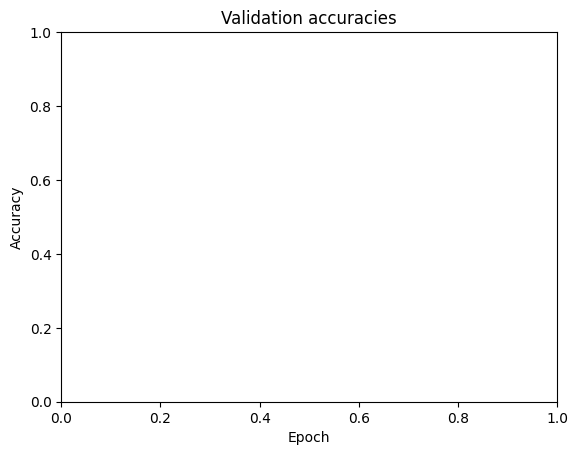

In [53]:
plt.title('Validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.plot(torch.tensor(accuracies).cpu().numpy())

plt.show()

In [66]:
study.best_params
study.best_value
study.trials
joblib.dump(study, 'study.pkl')

['study.pkl']

In [ ]:
study2 = joblib.load('study.pkl')

In [54]:
load_checkpoint(model, optimizer)
print('Checkpoint loaded')

test_accuracy = get_model_accuracy(model, test_data_loader)

print(f'Test accuracy: {100 * test_accuracy:.2f}%')

NameError: name 'model' is not defined